# 프로젝트 : Transformer로 번역기 만들기

## 1. 데이터 준비하기

## 2. 모델 설계하기

## 3. 모델 학습하기

## 4. 모델 학습 결과

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn # Attention 시각화를 위해 필요!

import re, os, io, time, random

print(tf.__version__)

2.6.0


- - -
### 데이터 준비하기

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    
    cleaned_corpus = []
    
    for k, e in set(zip(kor, eng)):
        if abs(len(k.split()) - len(e.split())) > 20: continue;
        if len(k.split()) >= len(e.split())*2: continue;
        if len(e.split()) >= len(k.split())*3: continue;
        if '사전' in k and len(k.split()) < 6: continue;
        if '어휘 :' in k: continue;
        if '#' in e: continue;
        if bool(re.match(r'["a-zA-Z"]{5}', k)): continue;
        
        cleaned_corpus.append(k + '\t' + e)

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)
len(cleaned_corpus)

71276

In [ ]:
for i in range(5):
    print(">> ", cleaned_corpus[i])
    print()

>>  구명보트에 탈 수 없어 차가운 바다에 들어간 사람 중 몇 명만이 살아 남았다.	Only a small number of those unable to find a place on the boats survived the freezing waters.

>>  다이아나 왕세자비와 도디 알 파예드가 살해당했다고, 1997년 파리에서의 자동차 사고로 이들이 사망한 사건에 대해 조사하는 과정에서 도디의 부친 모하메드 알 파예드가 주장했다.	Princess Diana and Dodi Al Fayed were murdered, Dodi´s father Mohamed Al Fayed has told the inquest into their deaths in a car crash in Paris in 1997.

>>  원 조직명은 바아더-마인호프 그룹으로 독일의 좌파그룹인 적군파는 지난 1970년부터 1991년까지 기업 총수와 고위 관리 등 34명을 살해한 것으로 보고됐다.	Also known as the "Baader-Meinhof Gang" after founders Andreas Baader and Ulrike Meinhof, the militantly left wing RAF is believed to have killed 34 people, including senior industry leaders and public officials, between 1970 and 1991.

>>  멕시코의 통신재벌 카를로스 슬림이 지난해 3월 이후 110억달러를 벌어들이며 600억달러(약 57조원)로 2위에 선정됐고 빌 게이츠 회장이 580억달러(약 55조원)로 3위에 선정됐다.	Mexican telecom tycoon Carlos Slim Helu was named the world's second richest man, with a net worth of around $60 billion, up $11 billion since last March.

>>  경제회

프로젝트04와 같은 데이터셋이므로 데이터를 불러오면서 동일한 전처리를 진행했습니다.

In [ ]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()
    
    sentence = re.sub(r"['¡°¡¦¡¯¡±]", "", sentence) # 노이즈 문자 제거
    sentence = re.sub(r"([#*+-/:;<=>@\[\]\"^_`{|}~])", "", sentence) # 특수문자 제거(일부 예외 처리함)
    sentence = re.sub(r"([$%&()?!',.])", r" \1 ", sentence) # 예외 처리한 특수문자들 주변에 공백 추가)
    sentence = re.sub(r"[' ']+", " ", sentence) # 여러 개의 공백은 하나의 공백으로

    sentence = sentence.strip()
    
    return sentence

`preprocess_sentence` 함수 또한 동일합니다.

In [ ]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
import sentencepiece as spm

def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):

    temp_file = os.getenv('HOME') + f'/aiffel/GoingDeeper/dataset/korean-english-park.train.{lang}.temp'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')

    spm.SentencePieceTrainer.Train(
    '--input={} \
     --model_prefix=temp_spm \
     --vocab_size={} \
     --pad_id={} \
     --bos_id={} \
     --eos_id={} \
     --unk_id={}'.format(
        temp_file, 
        vocab_size, 
        pad_id, 
        bos_id, 
        eos_id, 
        unk_id)    
)
    s = spm.SentencePieceProcessor()
    s.Load('temp_spm.model')

    return s
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

kor_corpus = []
eng_corpus = []

for pair in cleaned_corpus:
    k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/GoingDeeper/dataset/korean-english-park.train.ko.temp      --model_prefix=temp_spm      --vocab_size=20000      --pad_id=0      --bos_id=1      --eos_id=2      --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/GoingDeeper/dataset/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: temp_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train

True

d_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
trainer_interface.cc(329) LOG(INFO) SentenceIterator is not specified. Using MultiFileSentenceIterator.
trainer_interface.cc(178) LOG(INFO) Loading corpus: /aiffel/aiffel/GoingDeeper/dataset/korean-english-park.train.en.temp
trainer_interface.cc(385) LOG(INFO) Loaded all 71272 sentences
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <pad>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <unk>
trainer_interface.cc(405) LOG(INFO) Normalizing sentences...
trainer_interface.cc(466) LOG(INFO) all chars count=9099385
trainer_interface.cc(477) LOG(INFO) Done: 99.9599% characters are covered.
trainer_interface.cc(487) LOG(INFO) Alphabet size=43
trainer_interface.cc(488) LOG(INFO) Final character coverage=0.999599
trainer_interface.cc(520) LOG(

이번에는 토크나이저를 한글과 영어 둘 다 단어 사전의 크기는 20000으로 해서 SentencePiece로 토큰화해주겠습니다.

In [ ]:
for i in range(5):
    print(">> ", kor_corpus[i])
    print(">> ", eng_corpus[i])
    print()

>>  구명보트에 탈 수 없어 차가운 바다에 들어간 사람 중 몇 명만이 살아 남았다
>>  only a small number of those unable to find a place on the boats survived the freezing waters

>>  다이아나 왕세자비와 도디 알 파예드가 살해당했다고 1997년 파리에서의 자동차 사고로 이들이 사망한 사건에 대해 조사하는 과정에서 도디의 부친 모하메드 알 파예드가 주장했다
>>  princess diana and dodi al fayed were murdered dodi´s father mohamed al fayed has told the inquest into their deaths in a car crash in paris in 1997

>>  원 조직명은 바아더마인호프 그룹으로 독일의 좌파그룹인 적군파는 지난 1970년부터 1991년까지 기업 총수와 고위 관리 등 34명을 살해한 것으로 보고됐다
>>  also known as the baadermeinhof gang after founders andreas baader and ulrike meinhof the militantly left wing raf is believed to have killed 34 people including senior industry leaders and public officials between 1970 and 1991

>>  멕시코의 통신재벌 카를로스 슬림이 지난해 3월 이후 110억달러를 벌어들이며 600억달러 ( 약 57조원 ) 로 2위에 선정됐고 빌 게이츠 회장이 580억달러 ( 약 55조원 ) 로 3위에 선정됐다
>>  mexican telecom tycoon carlos slim helu was named the worlds second richest man with a net worth of around $ 60 billion up $ 11 billion since last march

>

토큰화하기 전의 문장입니다.

In [ ]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    tokensko = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tokensen = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if 3 < len(tokensko) < 50 and 6 < len(tokensen) < 50:
        src_corpus.append(tokensko)
        tgt_corpus.append(tokensen)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/71276 [00:00<?, ?it/s]

In [ ]:
enc_train[0]

array([  560,    74, 11460,    13,  4440,    28,  2376,  8384,    94,
       10599,  5958,   332,    60,   205,   846,  1986,  3496,  8286,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [ ]:
print(ko_tokenizer.SampleEncodeAsPieces(kor_corpus[0], 1, 0.0))

['▁구', '명', '보트', '에', '▁탈', '▁수', '▁없어', '▁차가', '운', '▁바다에', '▁들어간', '▁사람', '▁중', '▁몇', '▁명', '만이', '▁살아', '▁남았다']


In [ ]:
print(ko_tokenizer.DecodeIds(src_corpus[0]))

구명보트에 탈 수 없어 차가운 바다에 들어간 사람 중 몇 명만이 살아 남았다


SentencePiece 한글 문장 토큰화 결과입니다.

In [ ]:
print(dec_train[0])
print(en_tokenizer.SampleEncodeAsPieces(eng_corpus[0], 1, 0.0))
print(en_tokenizer.DecodeIds(tgt_corpus[0]))

[   1  149    6  506  262    7  185   83  526    5  571    6  343   17
    4 2810 2891    4 5737   13 2075    2    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
['<s>', '▁only', '▁a', '▁small', '▁number', '▁of', '▁those', '▁un', 'able', '▁to', '▁find', '▁a', '▁place', '▁on', '▁the', '▁boats', '▁survived', '▁the', '▁freez', 'ing', '▁waters', '</s>']
only a small number of those unable to find a place on the boats survived the freezing waters


영어 문장도 토큰화가 정상적으로 진행됐습니다.

- - -
### 모델 설계하기

In [ ]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [ ]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.units = d_model
        self.n_heads = n_heads
        self.d_ff = d_ff
        self.drop = dropout
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [ ]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [ ]:
transformer = Transformer(
    n_layers = 2,
    d_model = 512,
    n_heads = 8,
    d_ff = 2048,
    src_vocab_size = SRC_VOCAB_SIZE,
    tgt_vocab_size = TGT_VOCAB_SIZE,
    pos_len = 50,
    dropout = 0.2,
    shared = True
)

레이어 블록의 수는 2개, 보캡 사이즈는 20000, pos_len은 50으로

나머지는 트랜스포머 논문에서 사용된 파라미터와 동일하게 설정해줬습니다.

In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    batch_loss = (loss / int(tgt.shape[1]))

    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

- - -
### 모델 학습하기

In [ ]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [ ]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

def Hyperparameters(model, epoch):
    print('Hyperparameters')
    print('> n_layers :', model.encoder.n_layers)
    print('> d_model :', model.units)
    print('> n_heads :', model.n_heads)
    print('> d_ff :', model.d_ff)
    print('> dropout :', model.drop)
    print()
    
    print('Training Parameters')
    print('> Warmup Steps :', learning_rate.warmup_steps)
    print('> Batch Size :', BATCH_SIZE)
    print('> Epoch At :', epoch)

In [ ]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 16
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    print('loss :', (total_loss.numpy() / (batch + 1)))
    print('Translations')
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)
    
    print()
    Hyperparameters(transformer, epoch+1)

/tmp/ipykernel_1944/3609222230.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 6.096493282058063
Translations
Input: 오바마는 대통령이다.
Predicted translation: president barack obama says president barack obama president barack obama says president barack obama president barack obama obama president barack obama president barack obama president barack obama in his obama president barack obama obama president barack obama obama president barack obama obama president barack obama president barack obama president
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of city is the city of city
Input: 커피는 필요 없다.
Predicted translation: if you cant rise
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the fires killed

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 1


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 5.0122596012576395
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is a key to president roh moohyun
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a specially popular in the city of city
Input: 커피는 필요 없다.
Predicted translation: coffee coffee is a coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the attack

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 2


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 4.261000216707805
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is obama to get the president to get the president to get the president to get the president to get the president
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the cities of cities
Input: 커피는 필요 없다.
Predicted translation: there is no need to need for the place
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in seven others

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 3


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 3.6467079697049836
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama  ⁇ s president obama is obama obama  ⁇ s obama obama obama  ⁇ 
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens are the cities of cities
Input: 커피는 필요 없다.
Predicted translation: no coffee has nor any other coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed when the seven deaths occurred

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 4


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 3.136285104827809
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is president
Input: 시민들은 도시 속에 산다.
Predicted translation: city is the city where they are in cities
Input: 커피는 필요 없다.
Predicted translation: coffee shops no need for coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 5


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 2.691193444772567
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is president
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens are part of the city
Input: 커피는 필요 없다.
Predicted translation: coffee shops
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 6


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 2.292255955791608
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is president bushs doo obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: they are the city in the city
Input: 커피는 필요 없다.
Predicted translation: coffee shops dont need the no necessary
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seven deaths

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 7


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 1.9765730599141984
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is president
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are the cities in the san
Input: 커피는 필요 없다.
Predicted translation: for anything
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 8


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 1.7452356421897037
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is calls by president obama  ⁇ s president obama obama obama calls obama obama obama calls obama do obama obama obama obama obama obama obama obama obama obama obama calls obama calls
Input: 시민들은 도시 속에 산다.
Predicted translation: they bank image in the city
Input: 커피는 필요 없다.
Predicted translation: the need for need need need need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed when seven seven aboard

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 9


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 1.5753892935325575
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is obama obama obama calls bys illinois obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are the majorest
Input: 커피는 필요 없다.
Predicted translation: coffee shops border wall measure no necessary
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were confirmed communist party

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 10


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 1.4554026127982487
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is president barack obama calls barack obama do barack obama
Input: 시민들은 도시 속에 산다.
Predicted translation: is a major image in the san michic maintains the city home
Input: 커피는 필요 없다.
Predicted translation: coffee shops loweri need need need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people confirmed seven deaths

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 11


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 1.357657866125999
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is barack obama
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city of
Input: 커피는 필요 없다.
Predicted translation: coffee shops lower
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were working to 22

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 12


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 1.2860086187264927
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are a part of a spot spot spot
Input: 커피는 필요 없다.
Predicted translation: coffee shops it dont need everything
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people have died in the seven night

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 13


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 1.2139671623398567
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is in obama
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city of is the great city
Input: 커피는 필요 없다.
Predicted translation: coffee shops made coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in seven deaths

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 14


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 1.1475182135563586
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama illinois
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the major ocean
Input: 커피는 필요 없다.
Predicted translation: coffee shops e e e ebert
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people have died in the collapsed deaths

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 15


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 1.1038412606150094
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama iss illinois president obama obama obama obamaest presidential day when president barack obama obama obama obama obama is obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: when they visited the site
Input: 커피는 필요 없다.
Predicted translation: there need for needs to happen at needs
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people seven aboard seven memorial work department official said

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 16


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 1.0670641785672308
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama marks ahead of obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: when they visited the site in the city
Input: 커피는 필요 없다.
Predicted translation: the need for violence called need need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people seven out of the seven

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 17


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 1.020394063859015
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama obama is president obama obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: they come on a busy street
Input: 커피는 필요 없다.
Predicted translation: the need for er called going
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: about seven people dead were dead

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 18


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 0.9952497603358603
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama obama is ahead of obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are the in the san jose august
Input: 커피는 필요 없다.
Predicted translation: the called look at for for recover first practice
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people have died in seven deaths officials working less than seven seven seven seven seven seven

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 19


  0%|          | 0/4254 [00:00<?, ?it/s]

loss : 0.9933742277488834
Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is now facing obama obama obama
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are the problems for they
Input: 커피는 필요 없다.
Predicted translation: the coffee was line immediately definitely
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seven deaths do the seven seven seven seven

Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.2

Training Parameters
> Warmup Steps : 4000
> Batch Size : 16
> Epoch At : 20


배치 사이즈를 16로 두고 20Epochs를 학습한 결과입니다.

성공적인 번역은 아니지만 그래도 확실히 RNN을 사용했던 어텐션 모델과는 다르게 loss가 내려가는 것이 확연히 보이고,

`오바마는 대통령이다.` 문장의 번역에는 obama와 president 라는 키워드가,  
`시민들은 도시 속에 산다.` 문장의 번역에는 city 라는 키워드가,  
`커피는 필요 없다.` 문장의 번역에는 coffee 라는 키워드가,  
`일곱 명의 사망자가 발생했다.` 문장의 번역에는 seven 이라는 키워드가 등장하고 있습니다.

- - -
### 모델 학습 결과

Input: 오바마는 대통령이다.
Predicted translation: obama is now facing obama obama obama
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


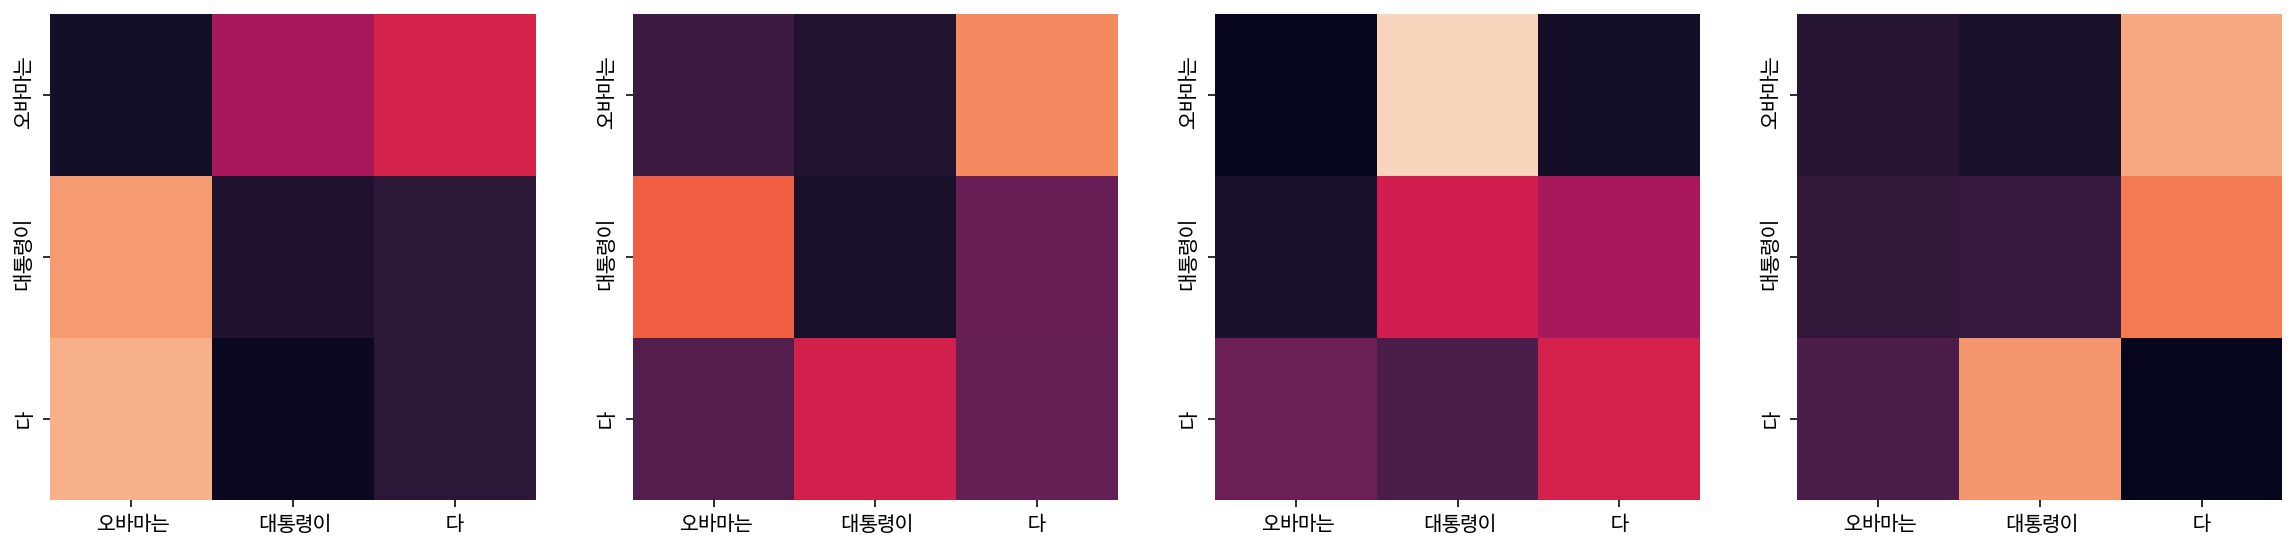

Encoder Layer 2


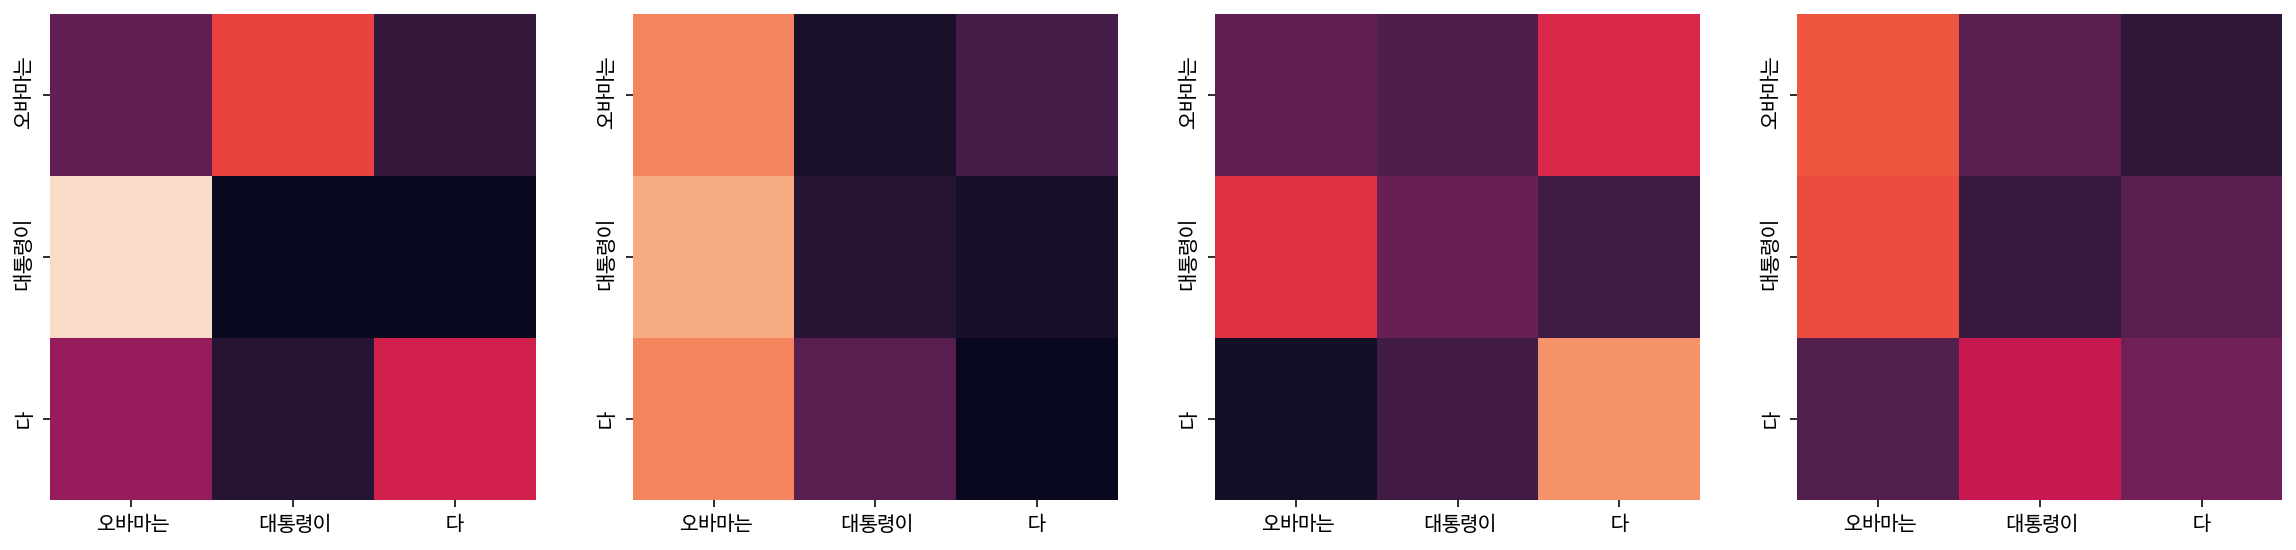

Decoder Self Layer 1


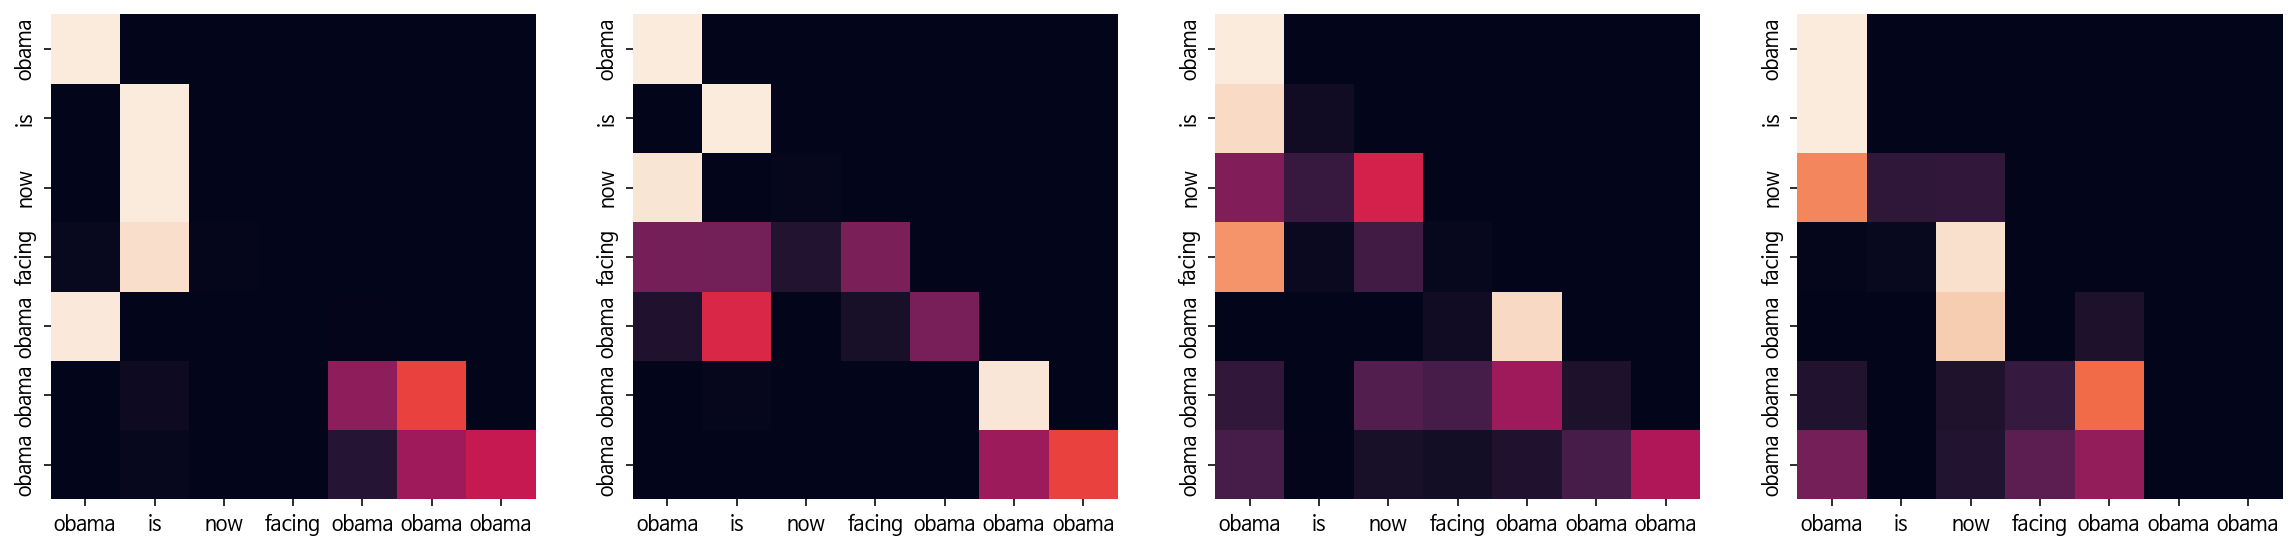

Decoder Src Layer 1


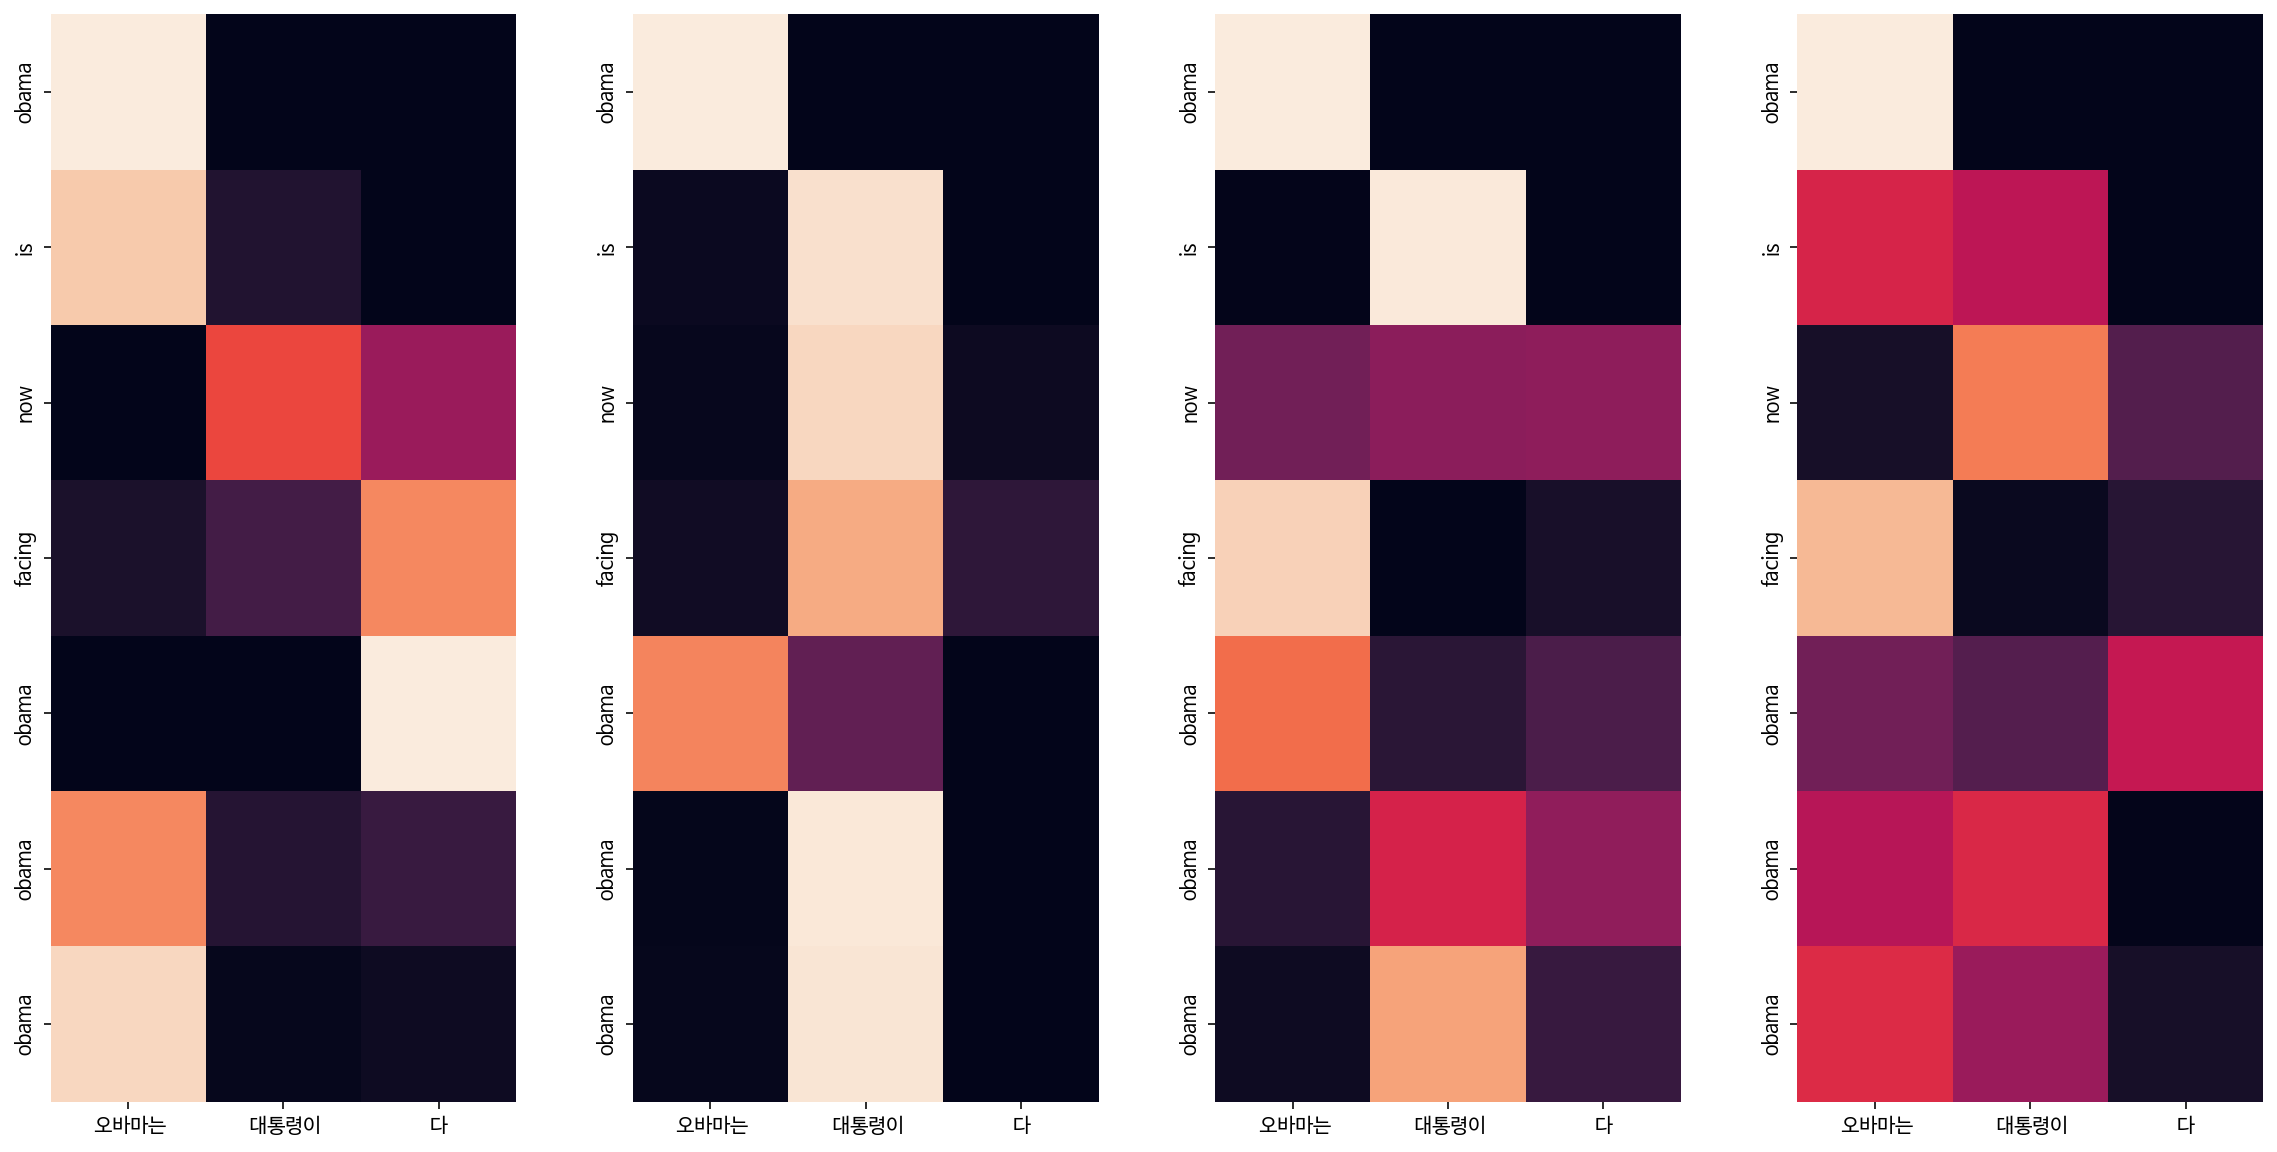

Decoder Self Layer 2


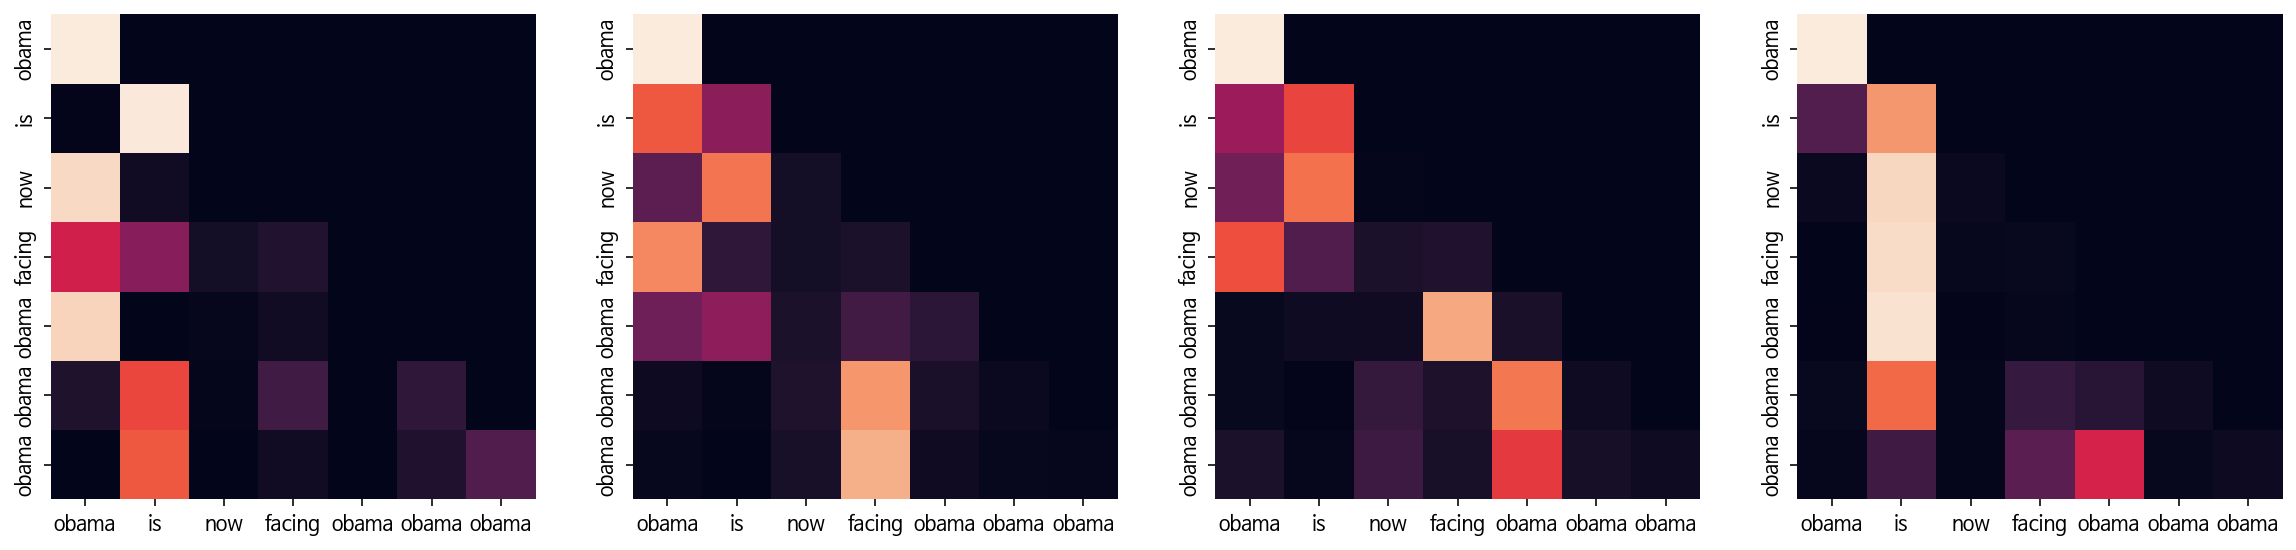

Decoder Src Layer 2


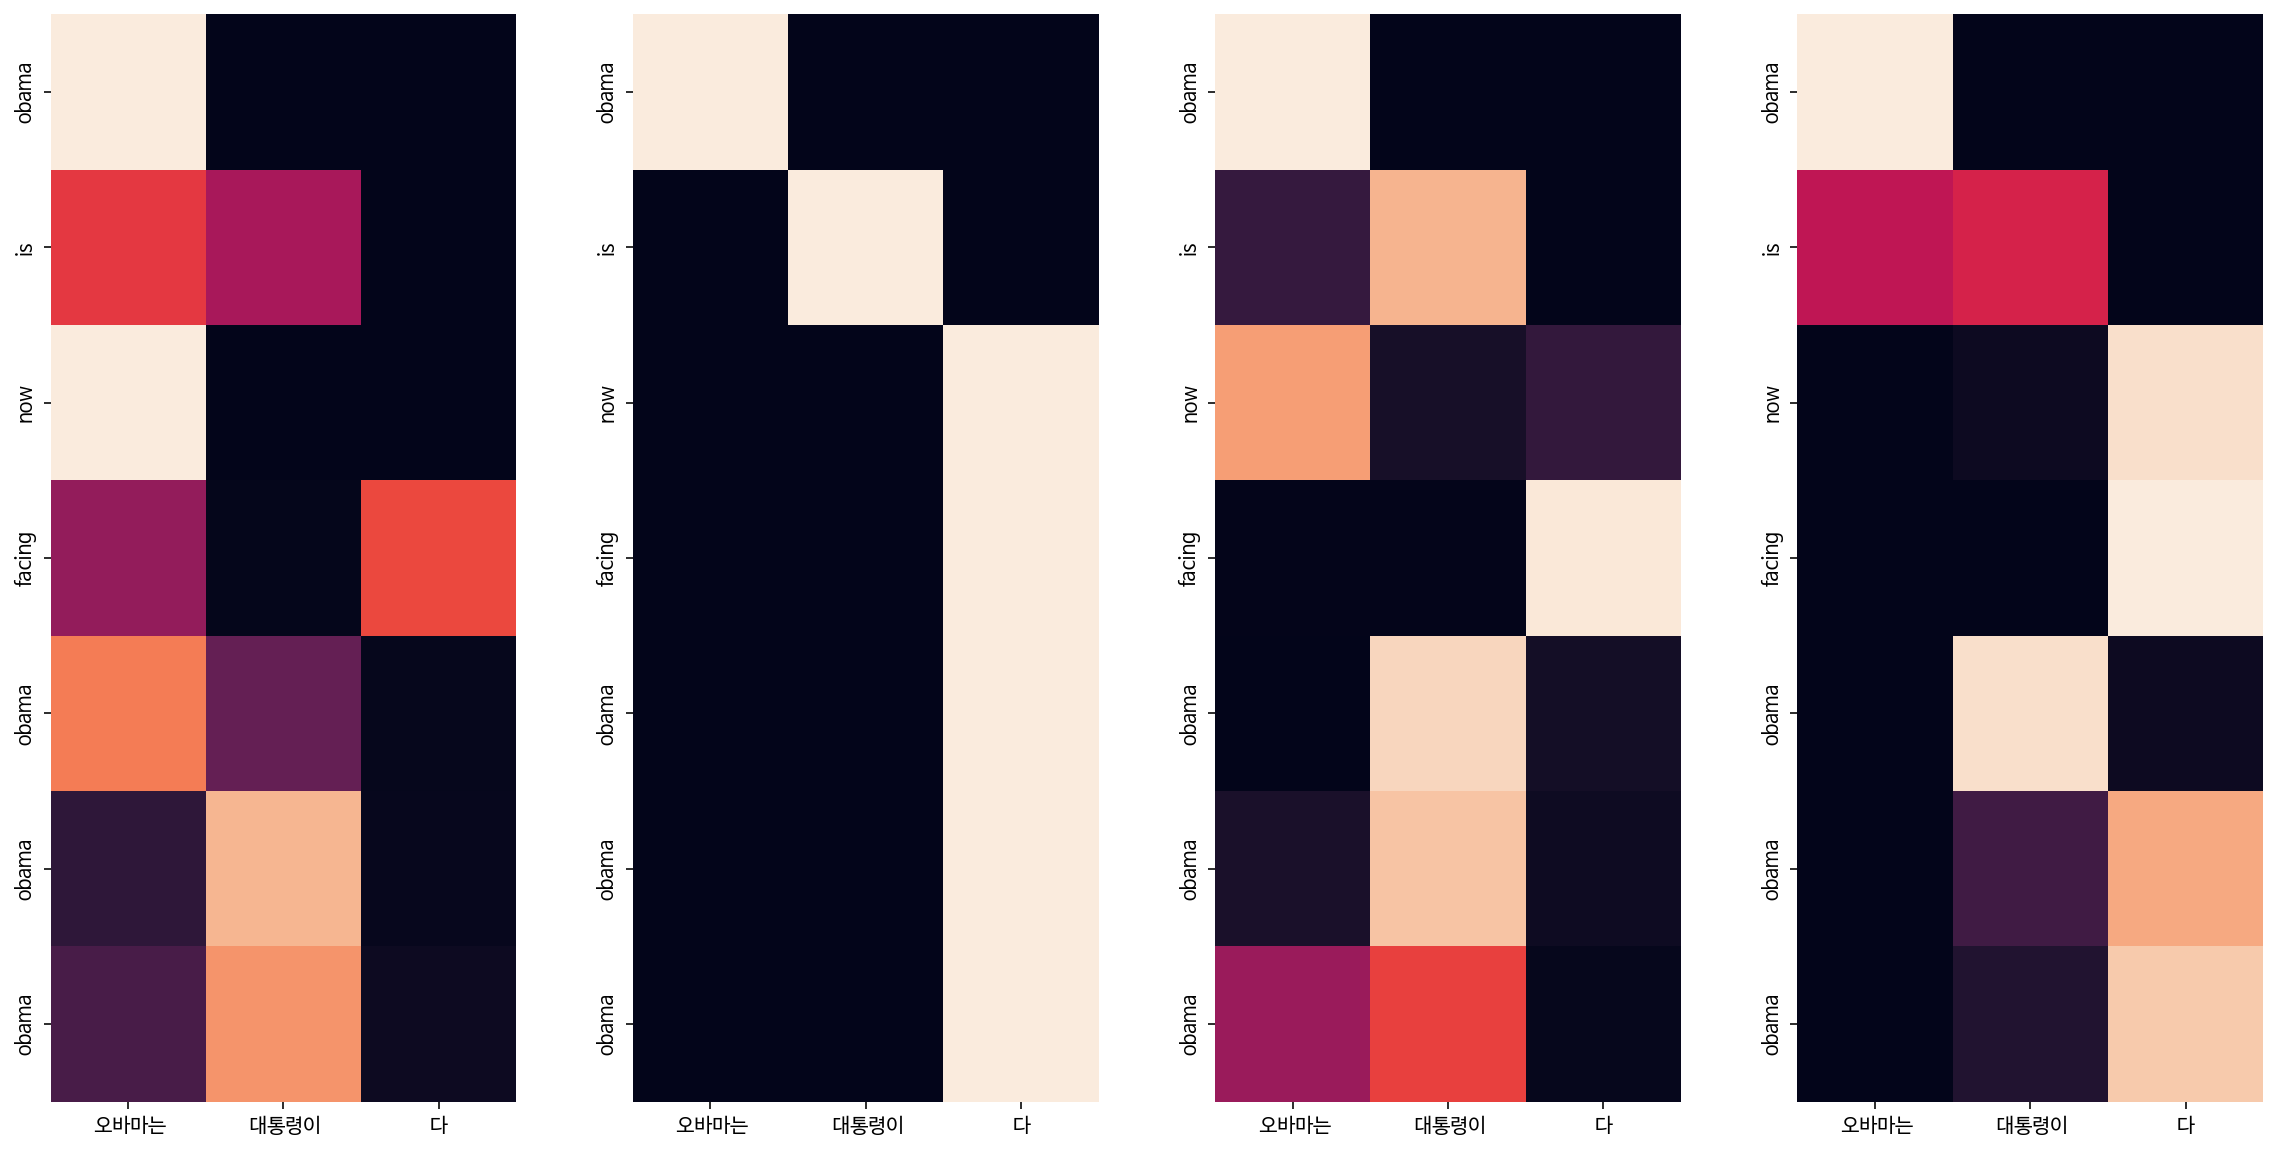

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are the problems for they
Encoder Layer 1


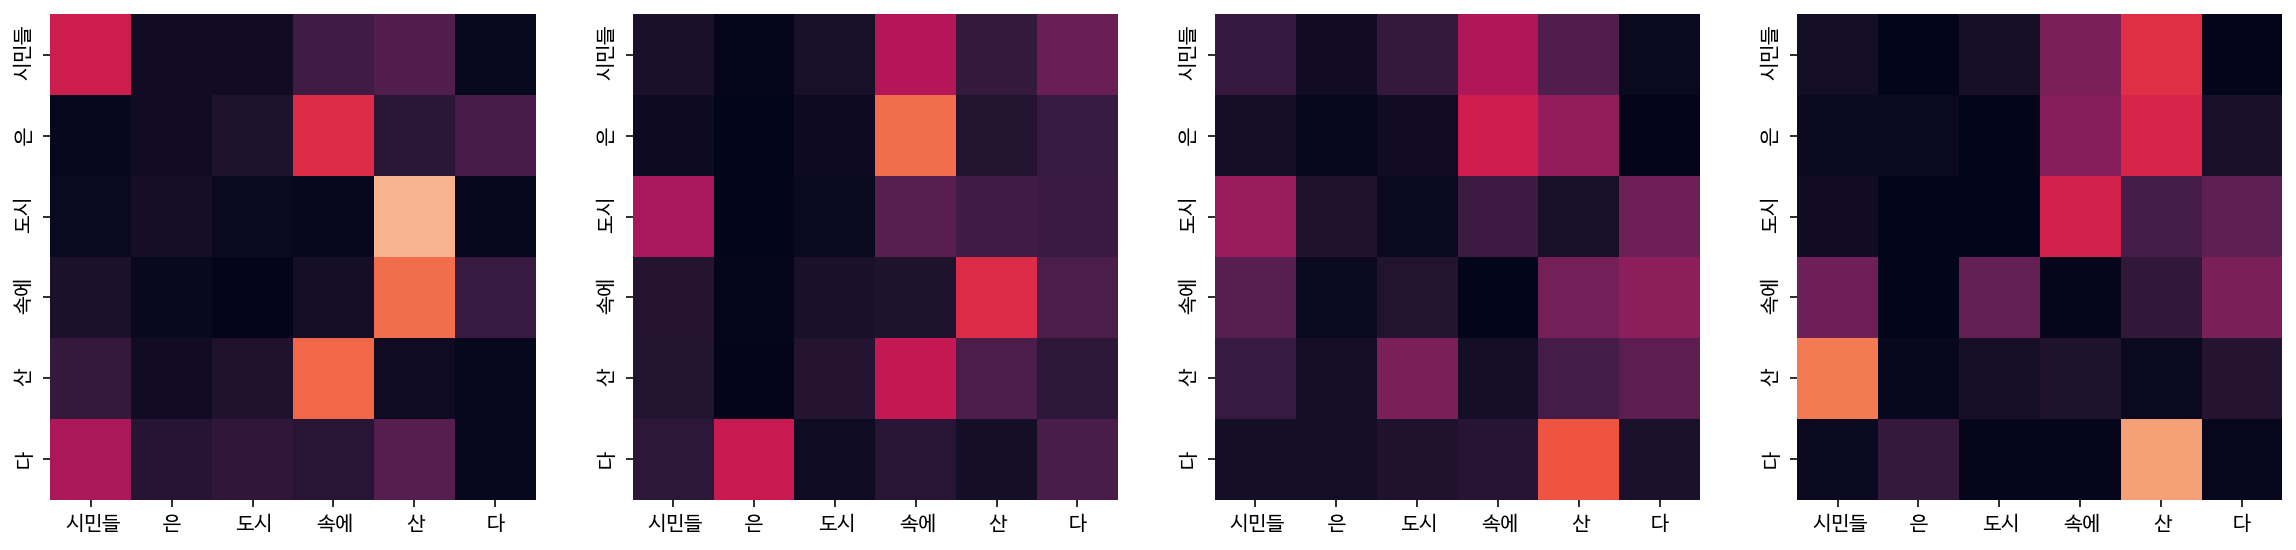

Encoder Layer 2


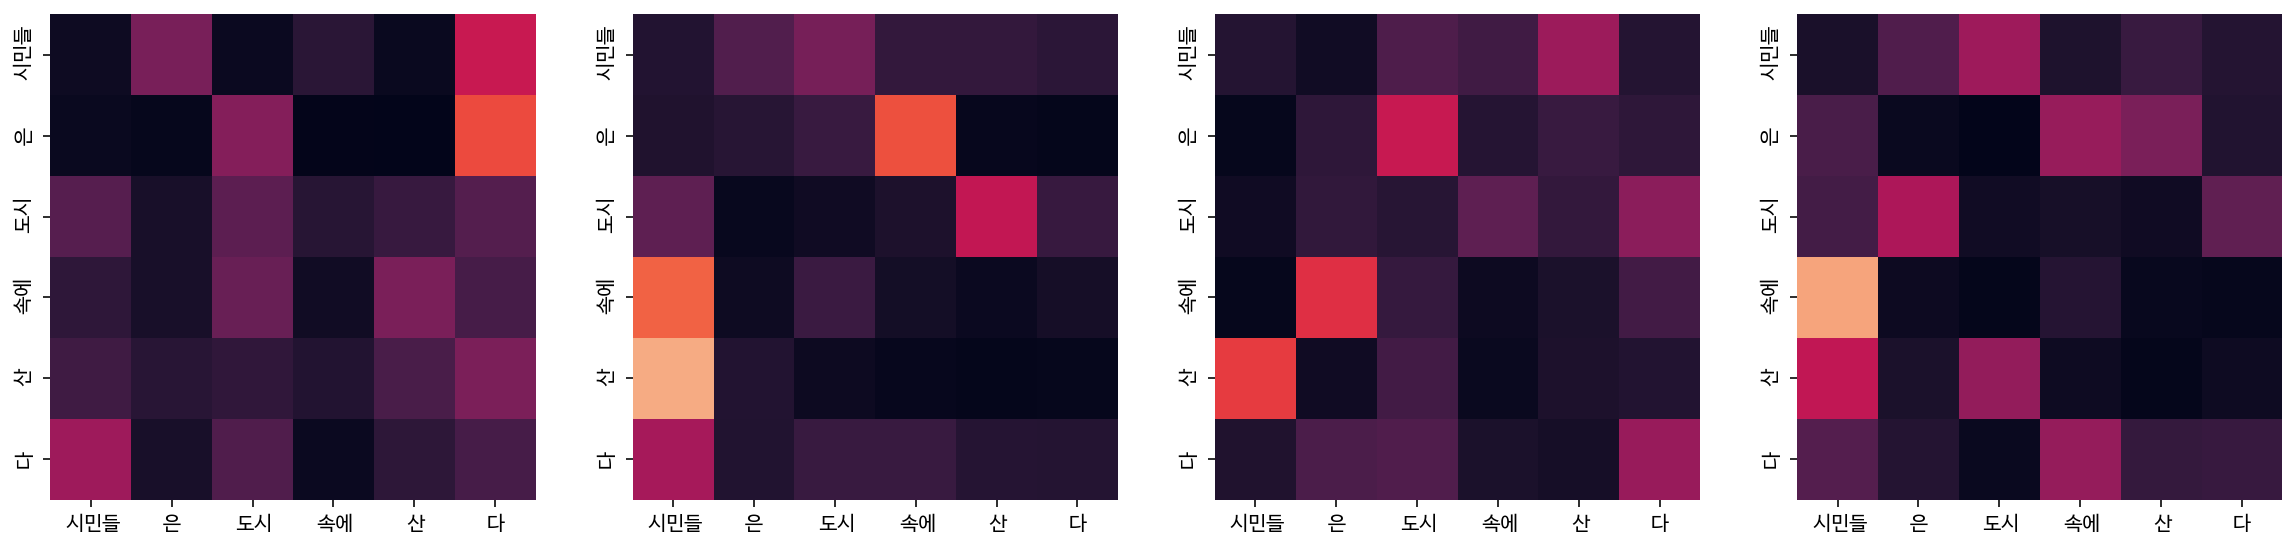

Decoder Self Layer 1


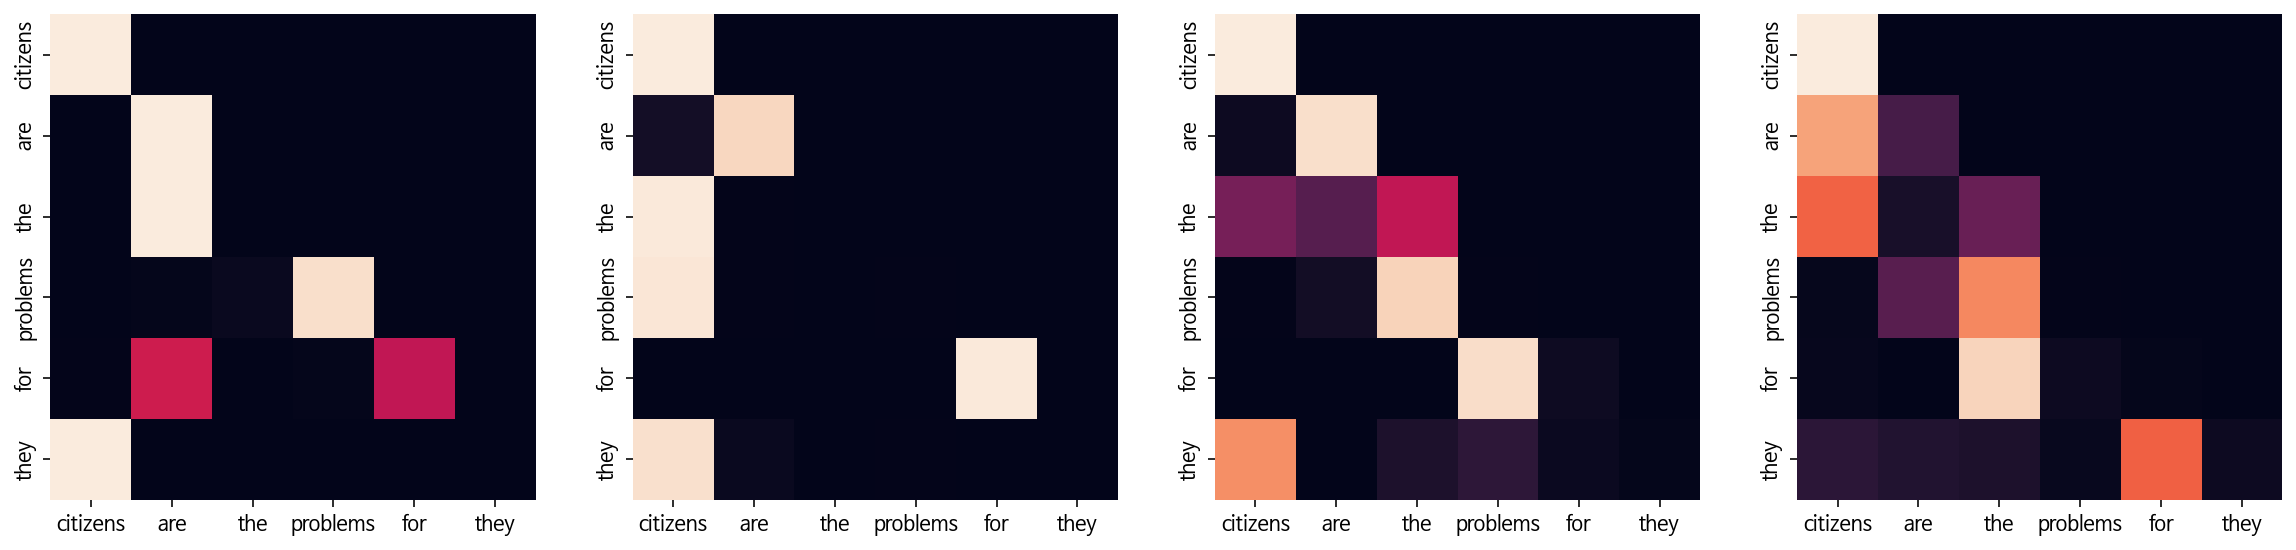

Decoder Src Layer 1


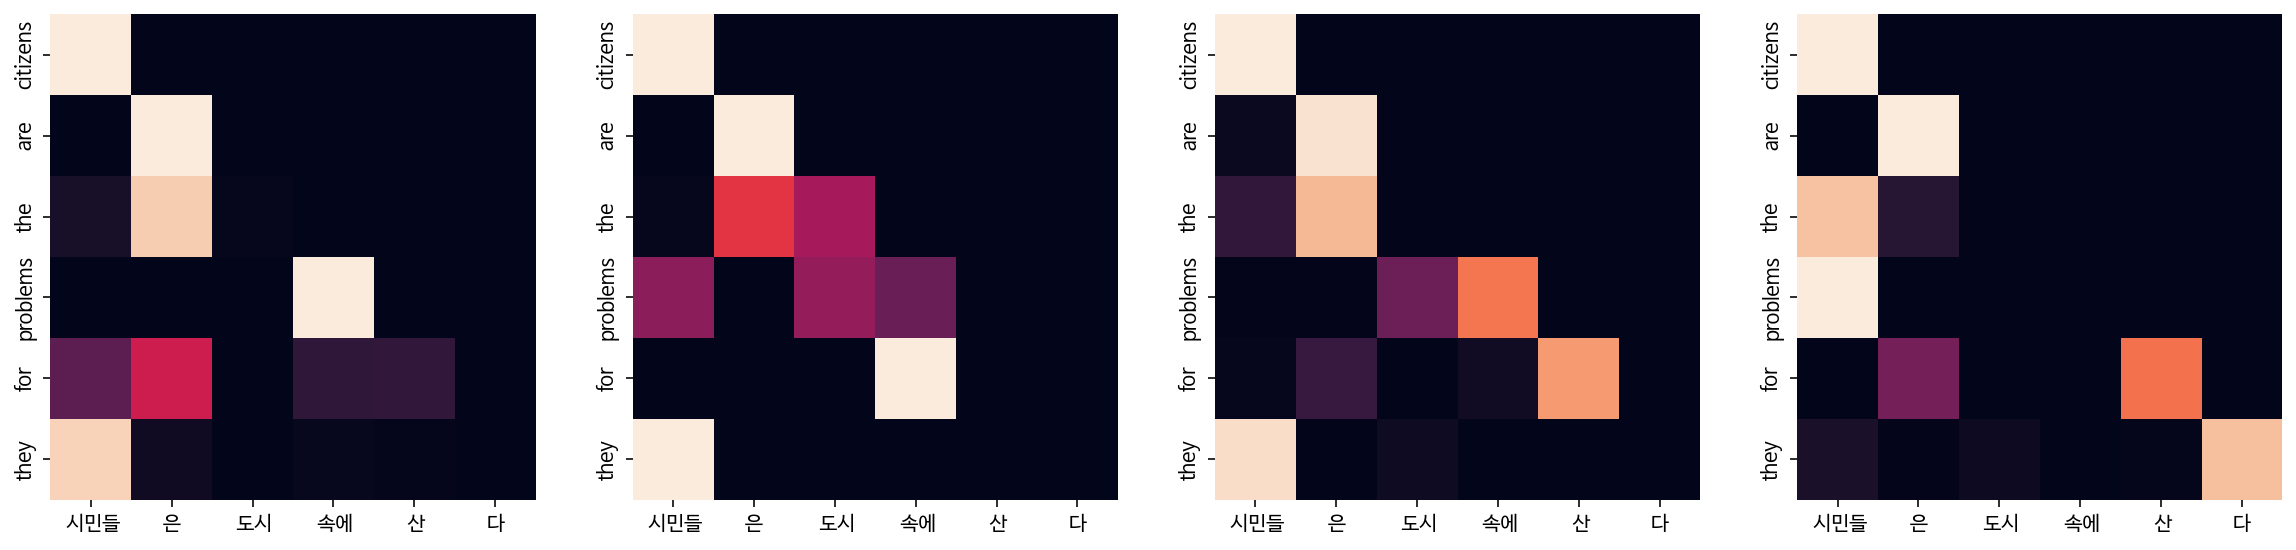

Decoder Self Layer 2


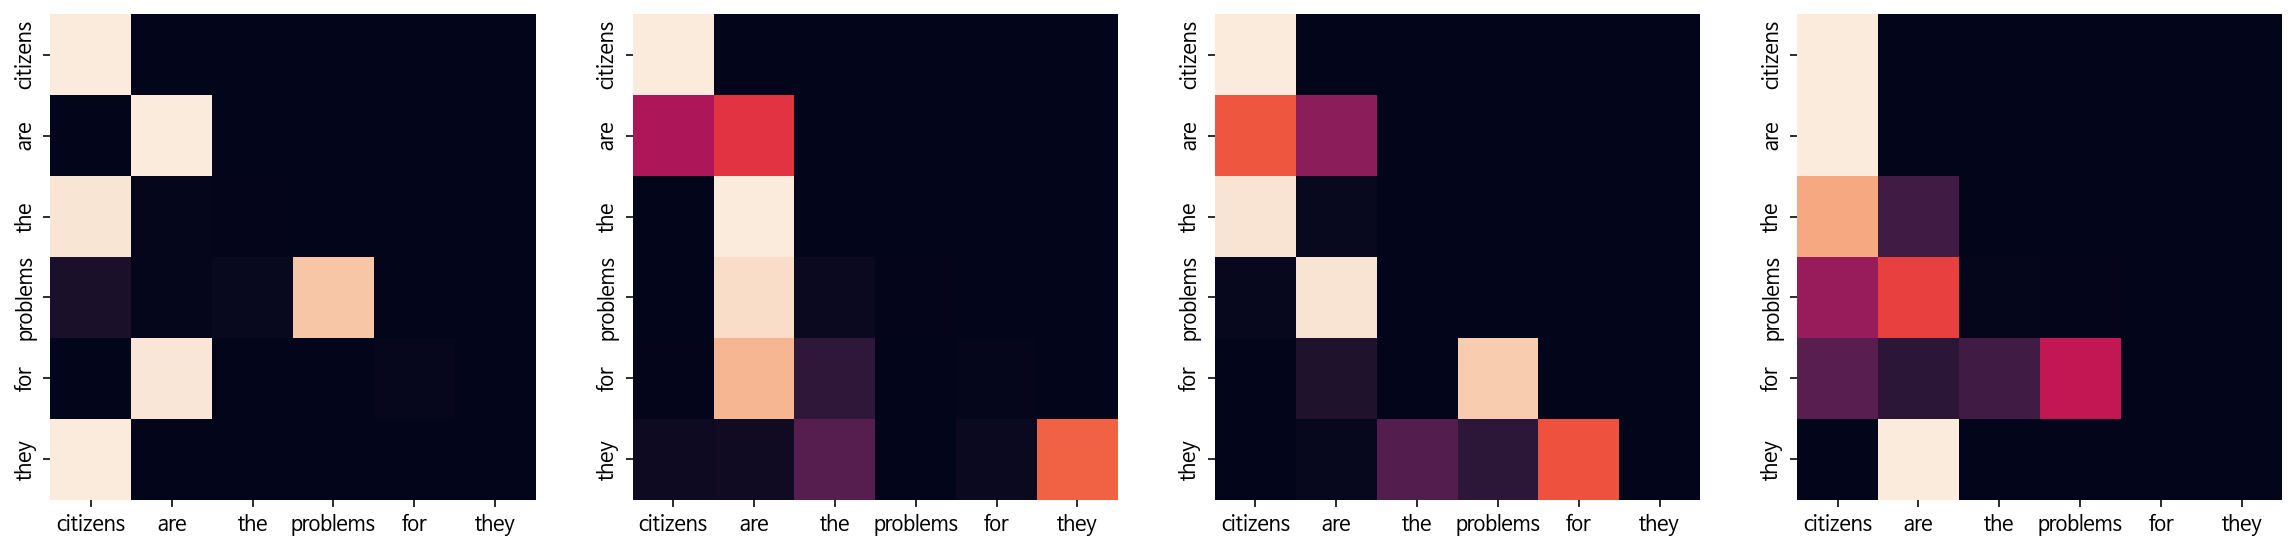

Decoder Src Layer 2


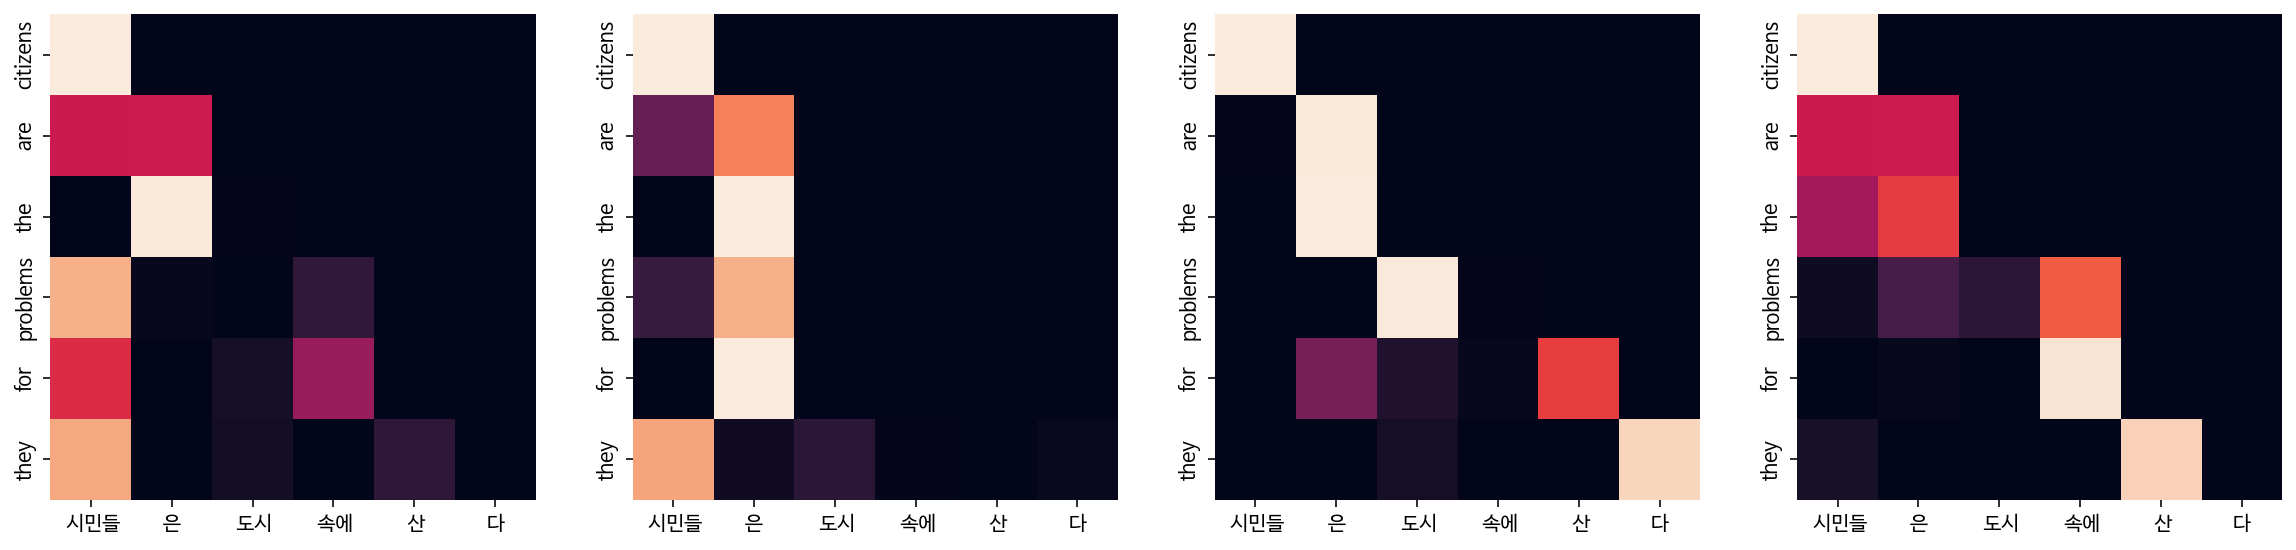

Input: 커피는 필요 없다.
Predicted translation: the coffee was line immediately definitely
Encoder Layer 1


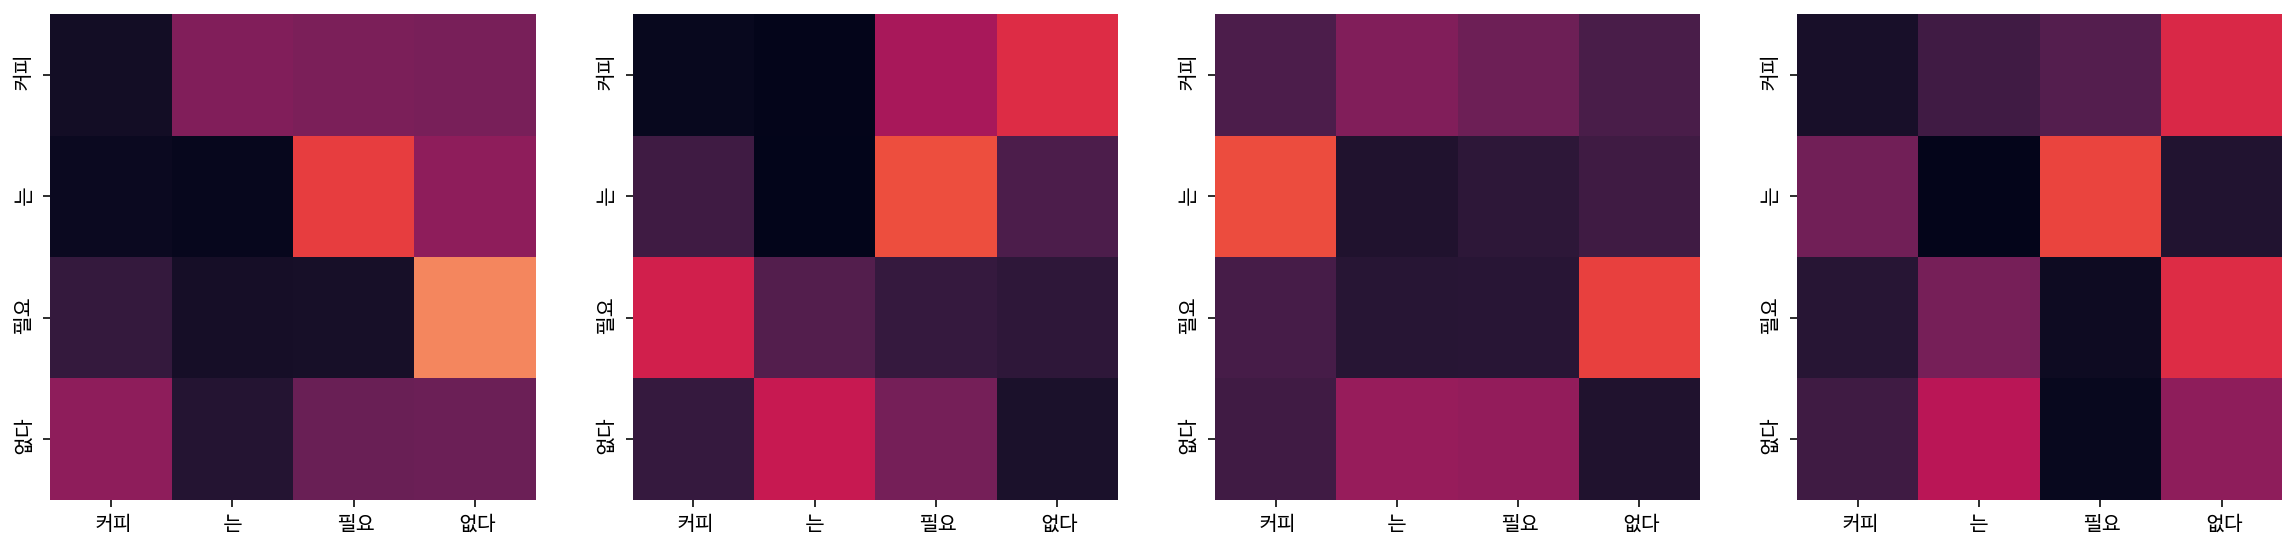

Encoder Layer 2


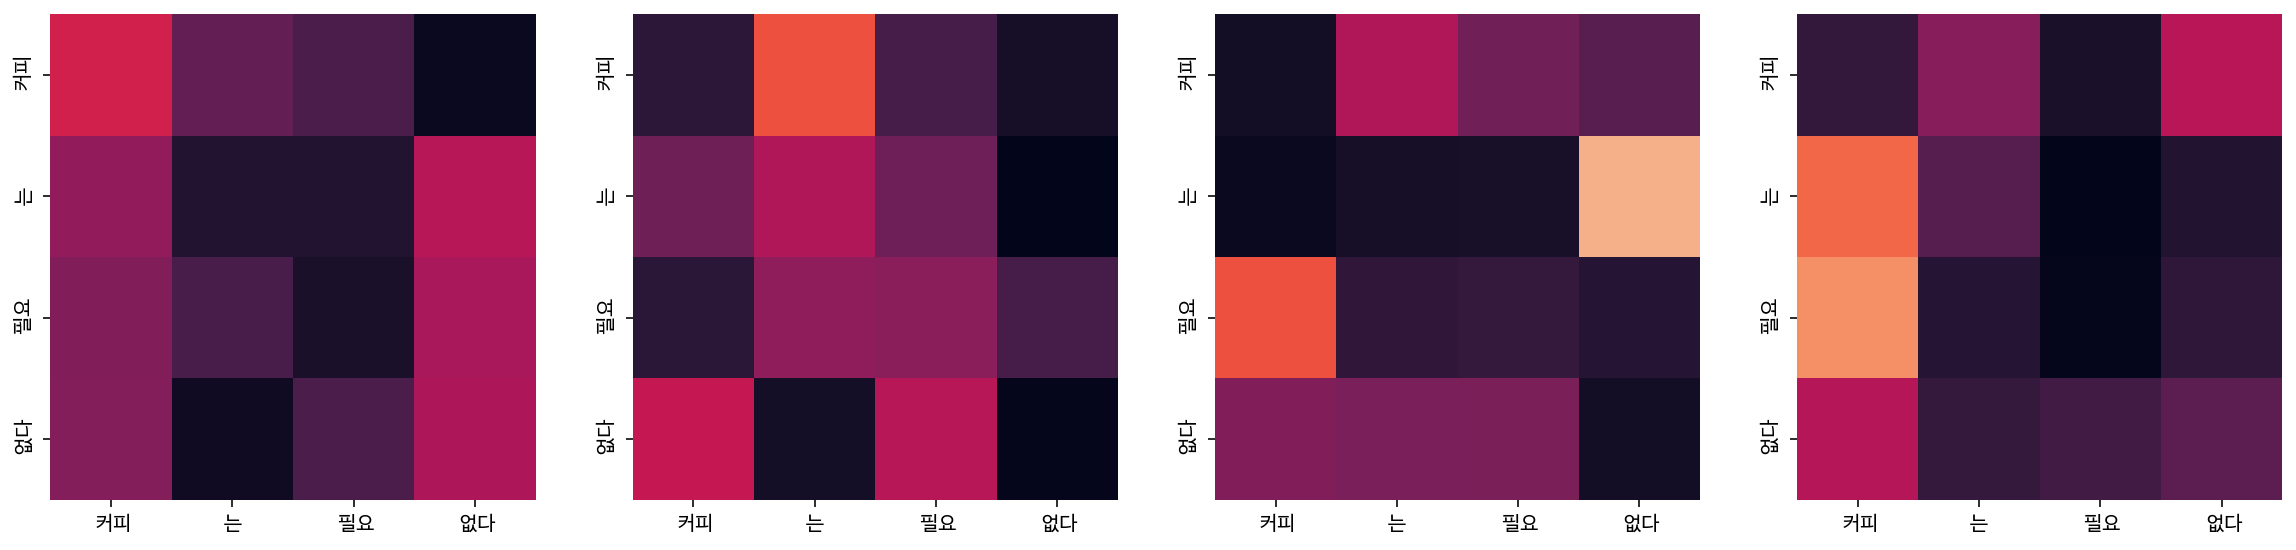

Decoder Self Layer 1


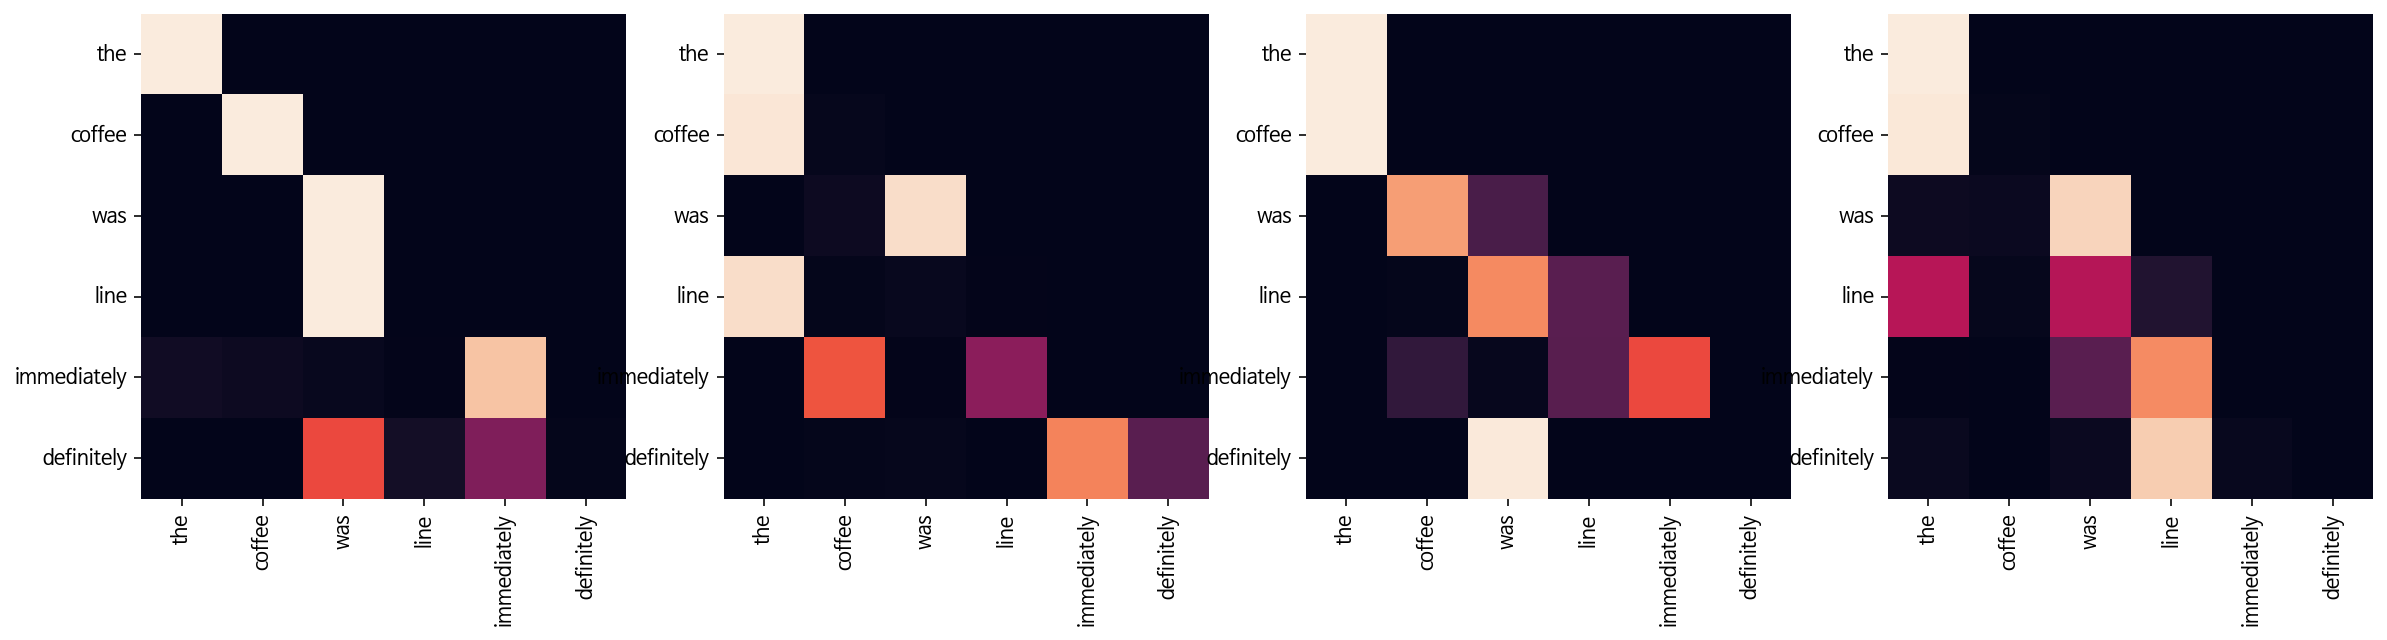

Decoder Src Layer 1


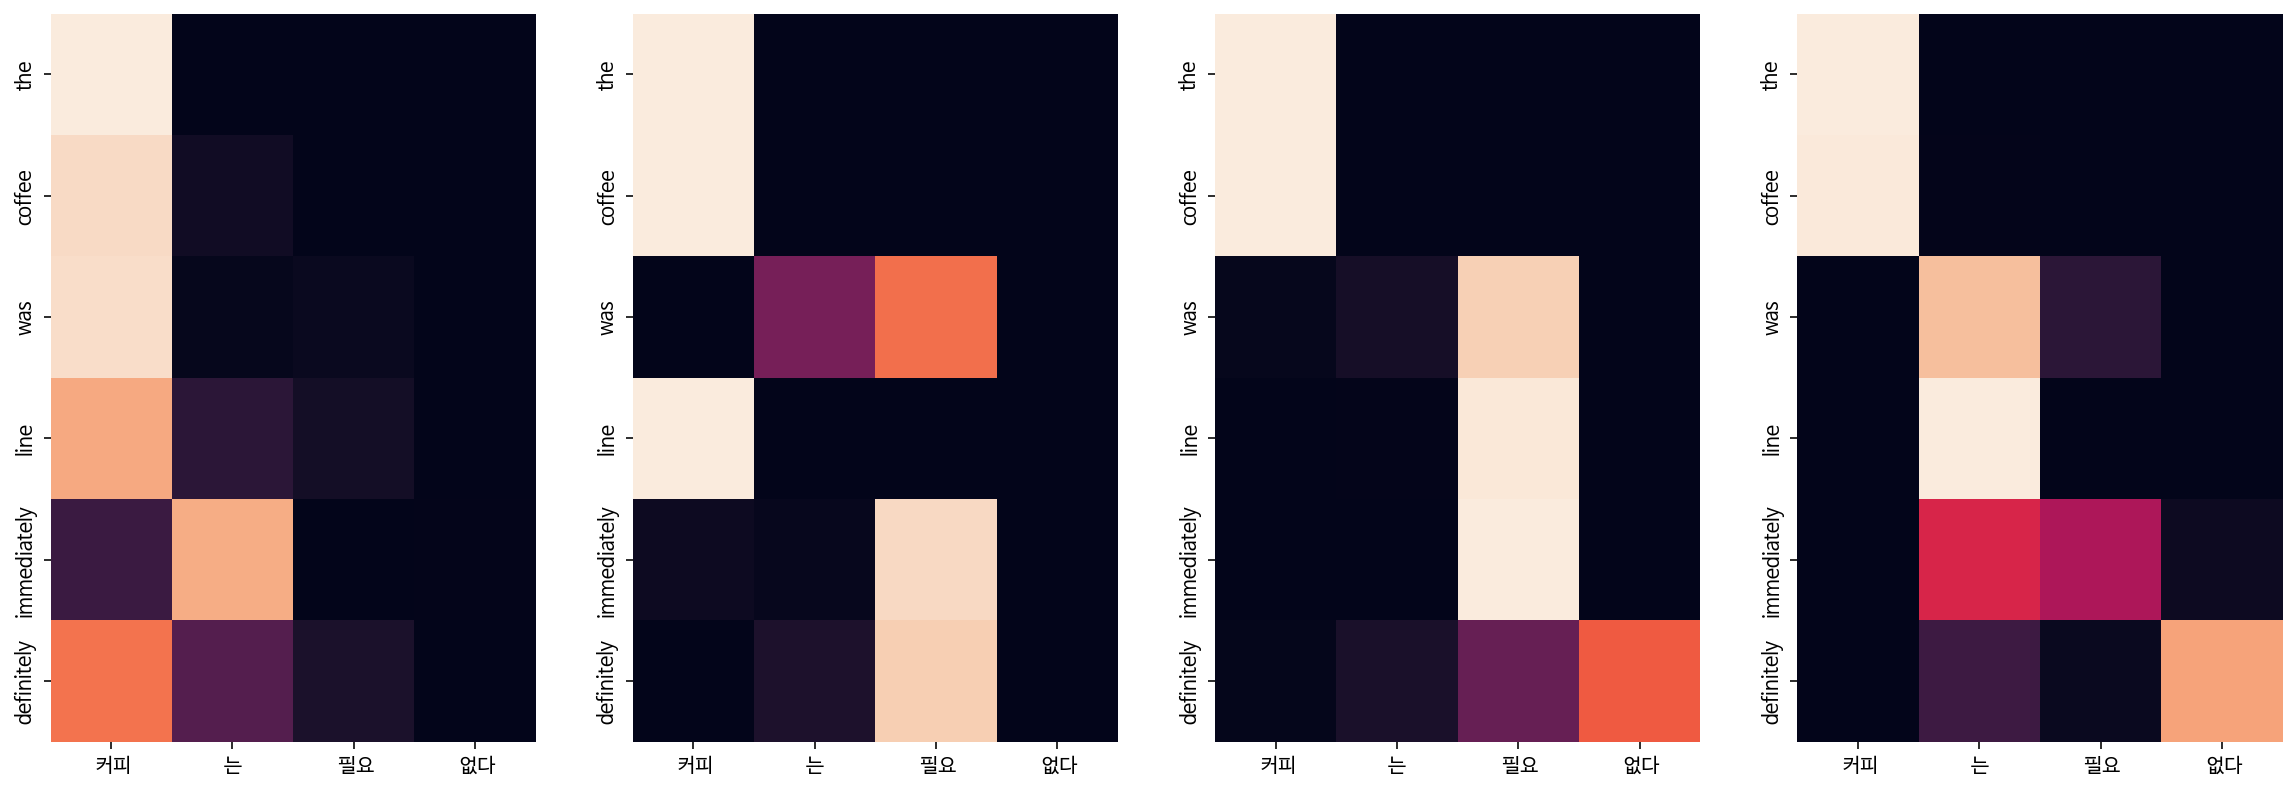

Decoder Self Layer 2


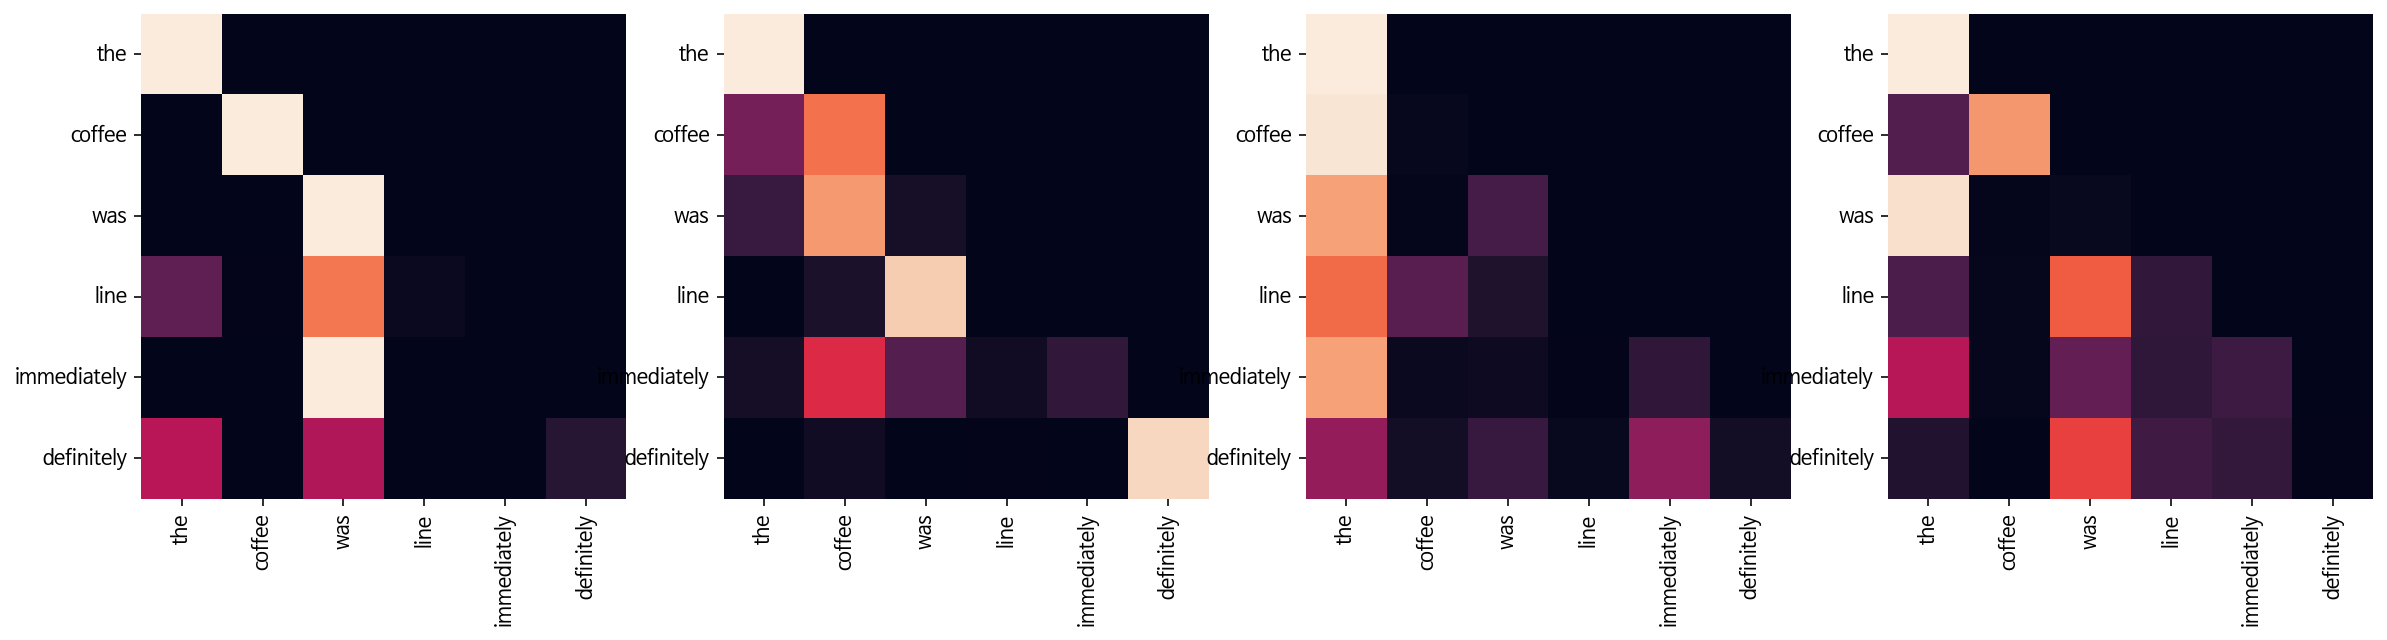

Decoder Src Layer 2


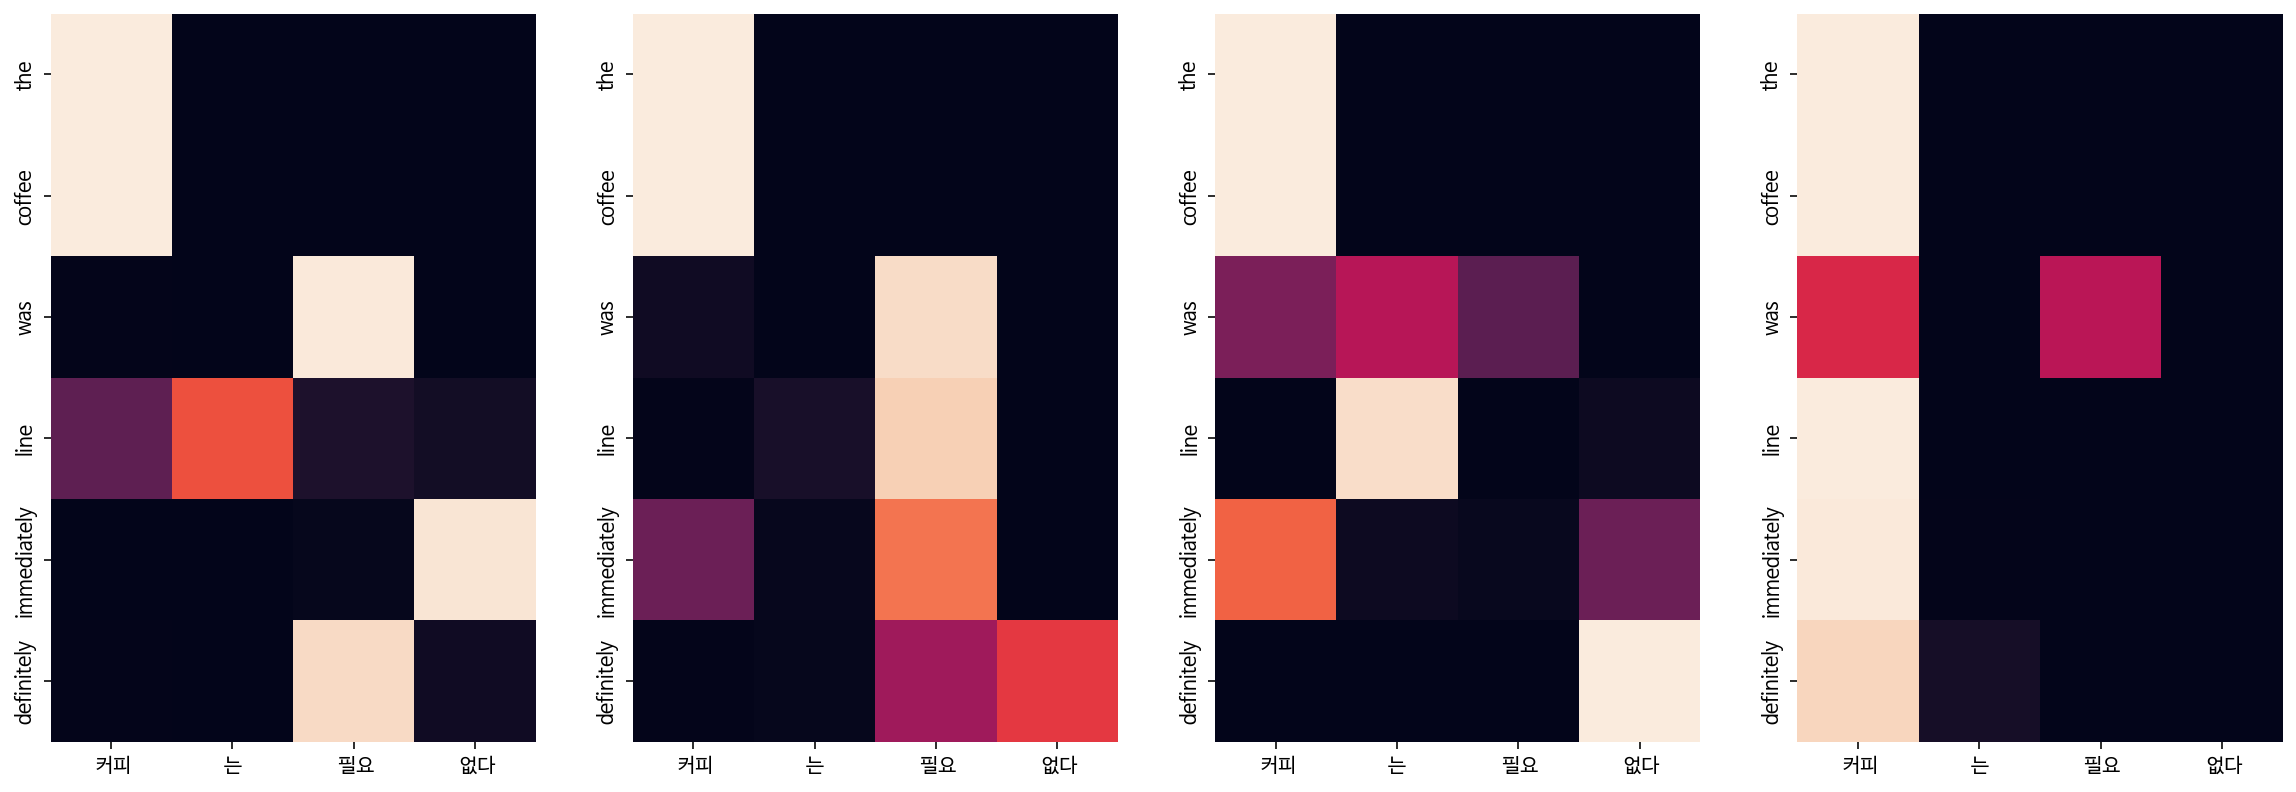

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seven deaths do the seven seven seven seven
Encoder Layer 1


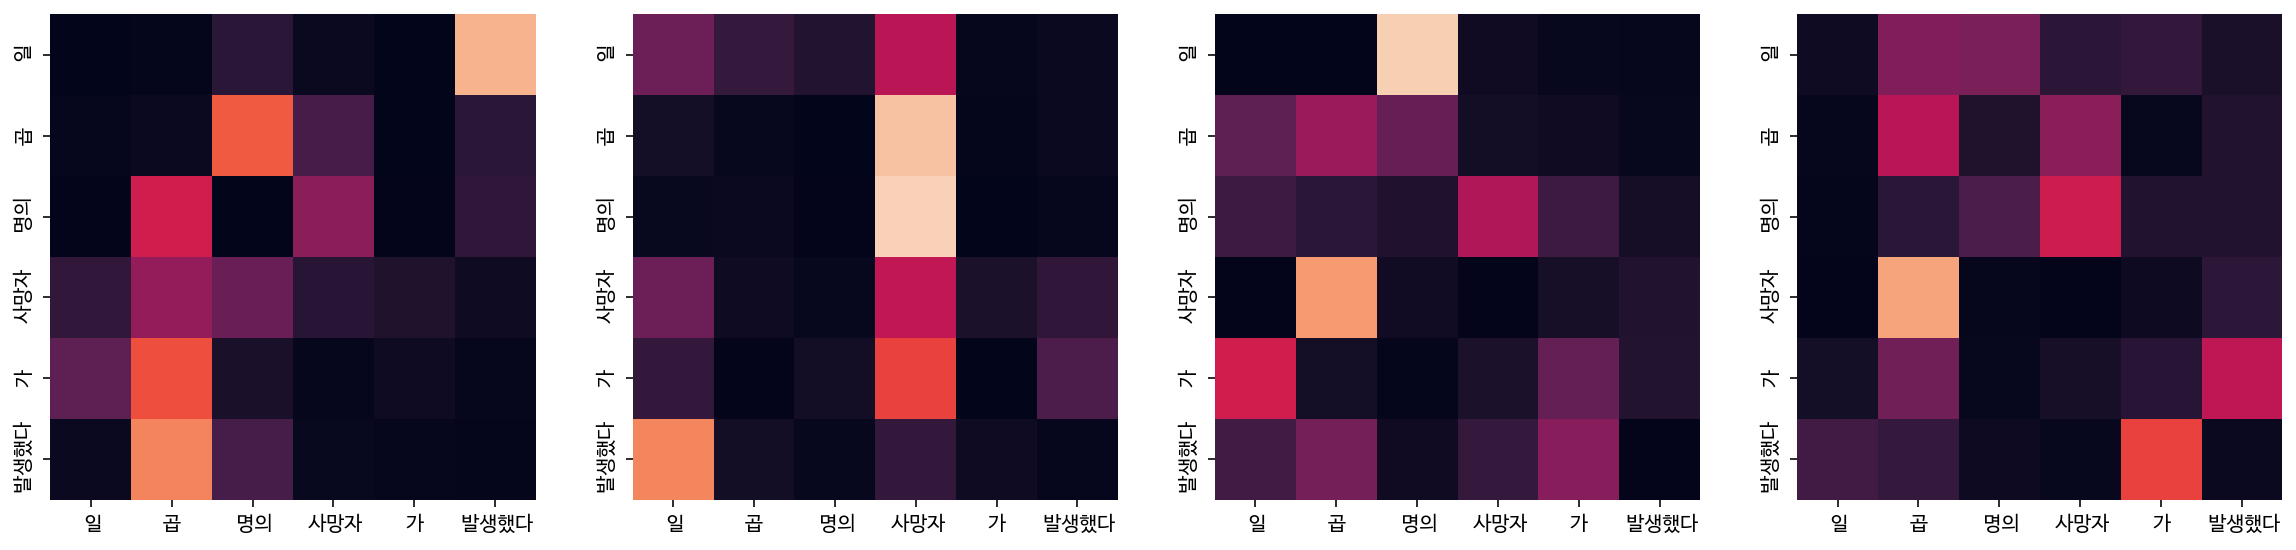

Encoder Layer 2


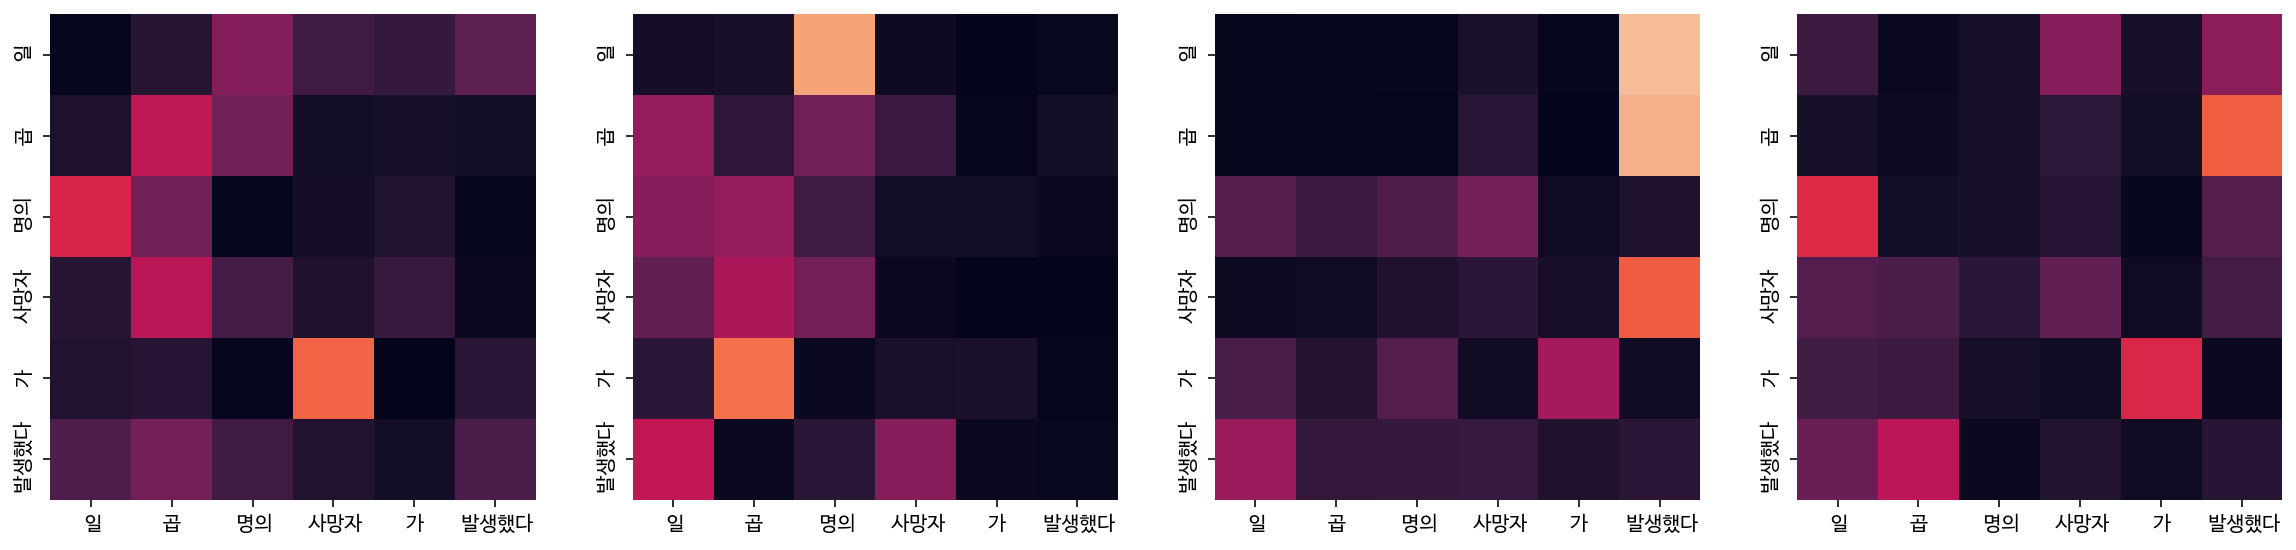

Decoder Self Layer 1


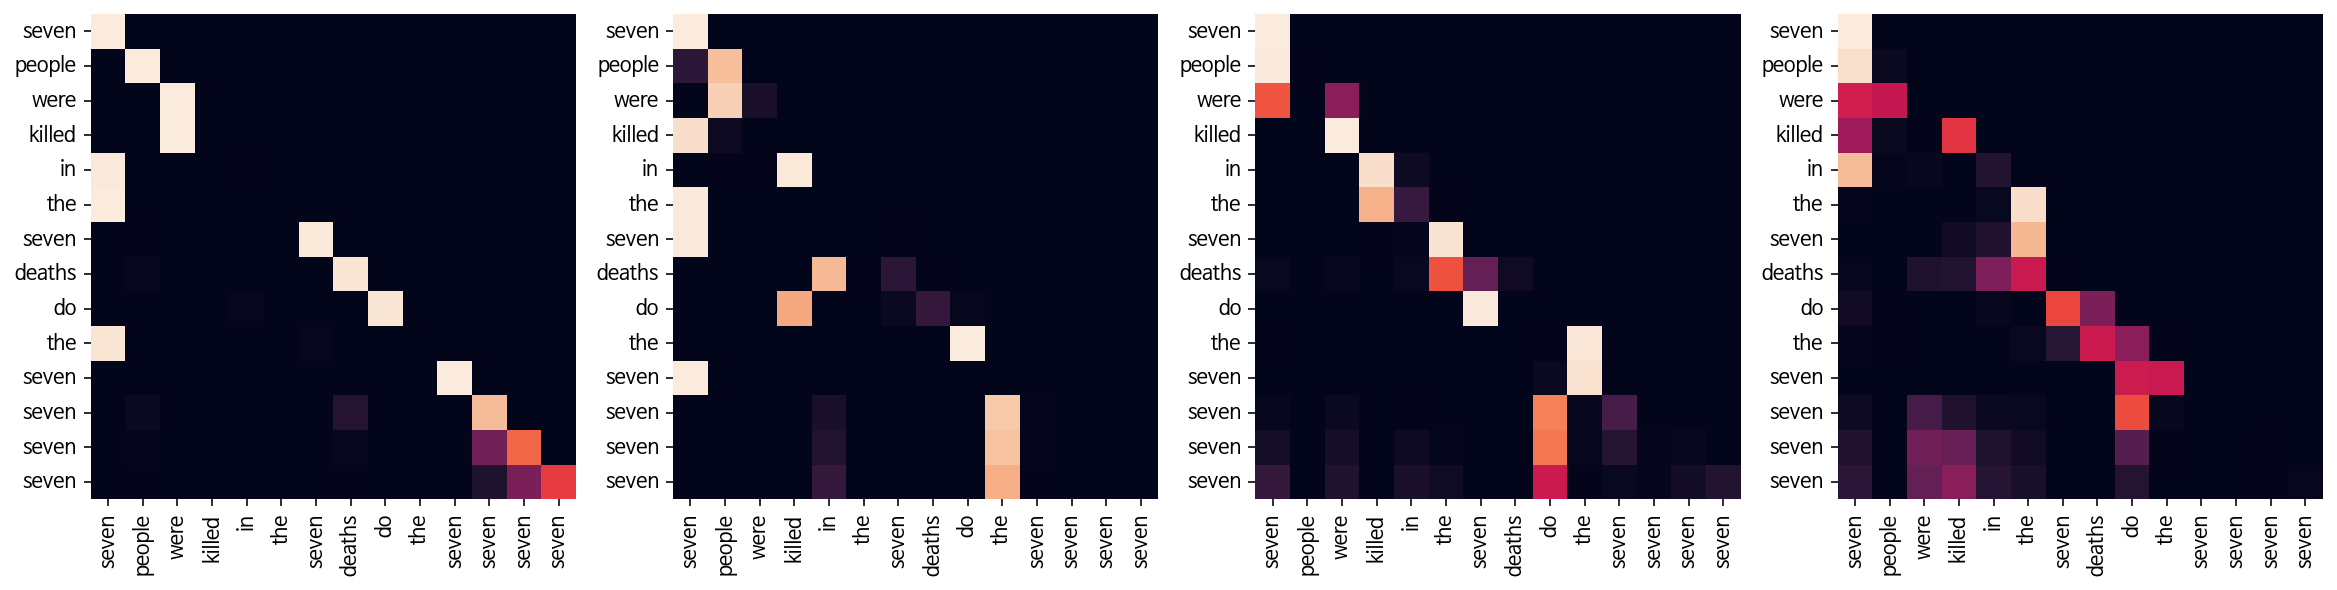

Decoder Src Layer 1


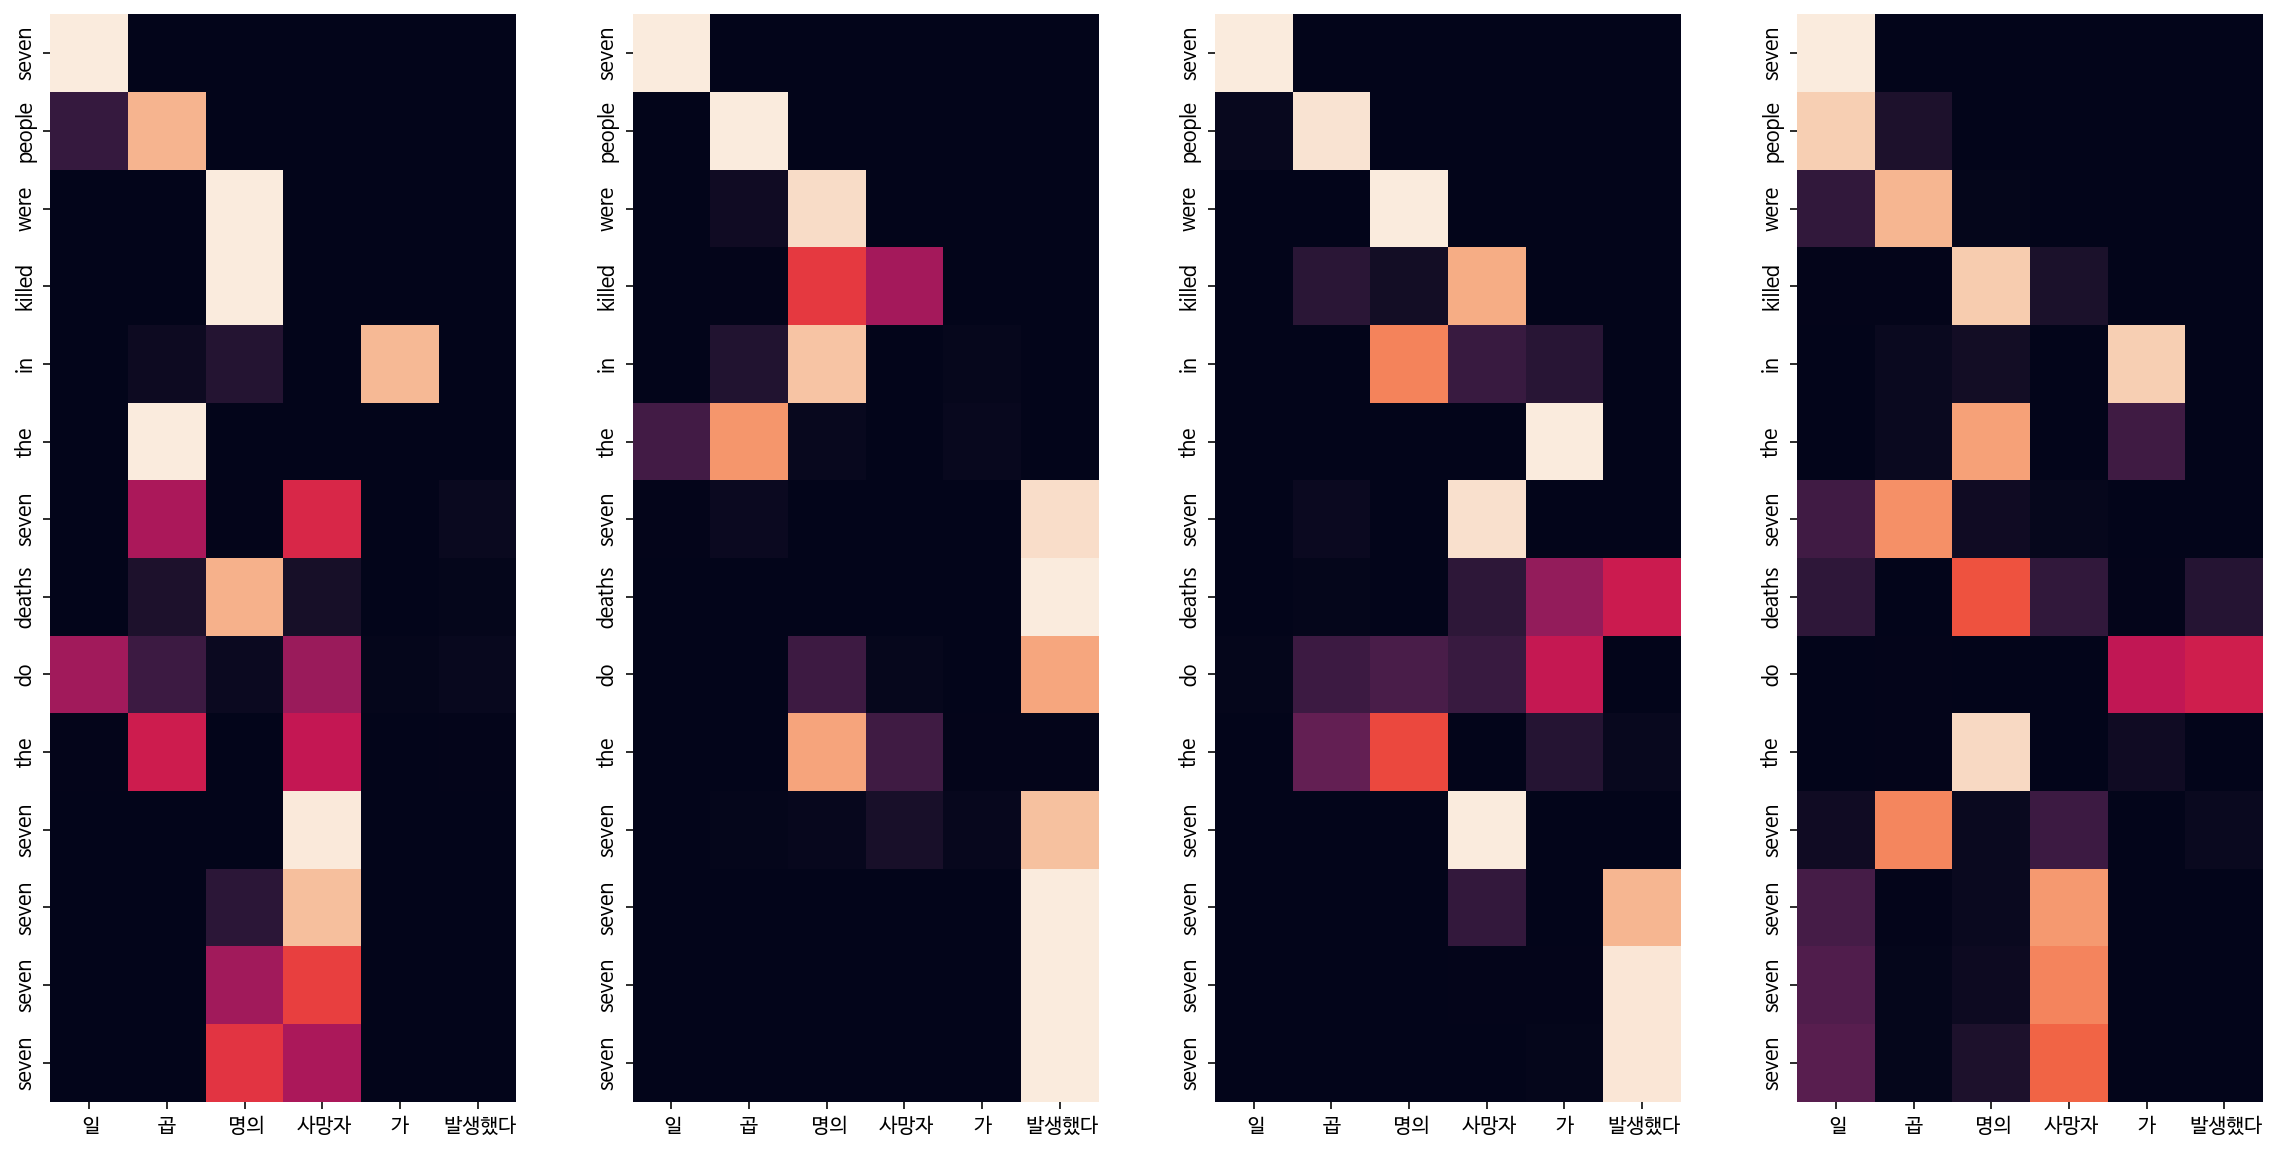

Decoder Self Layer 2


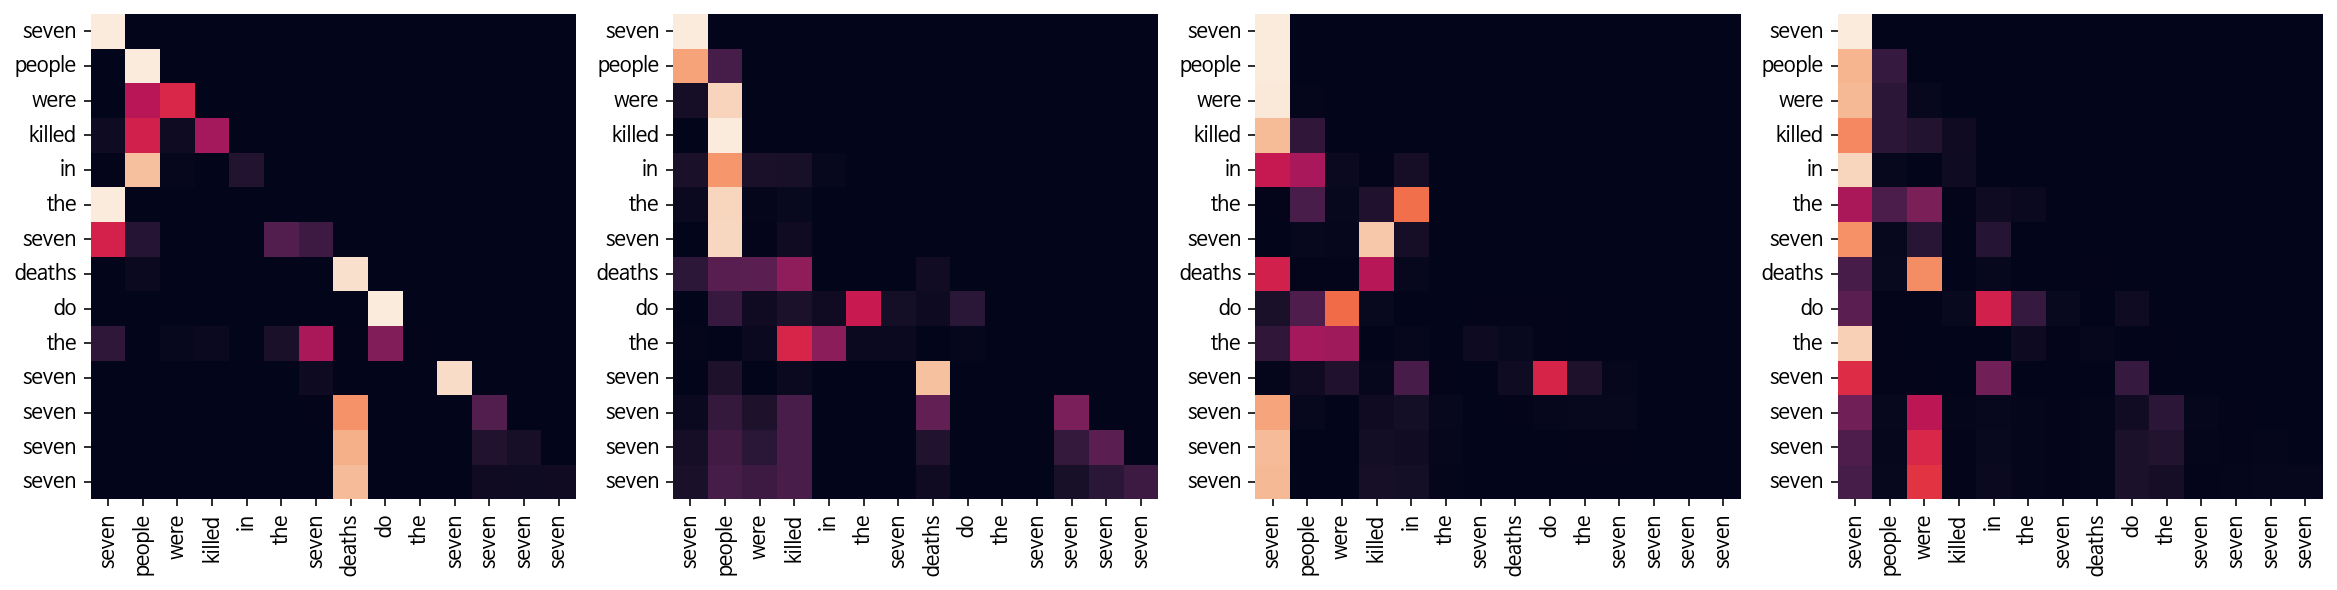

Decoder Src Layer 2


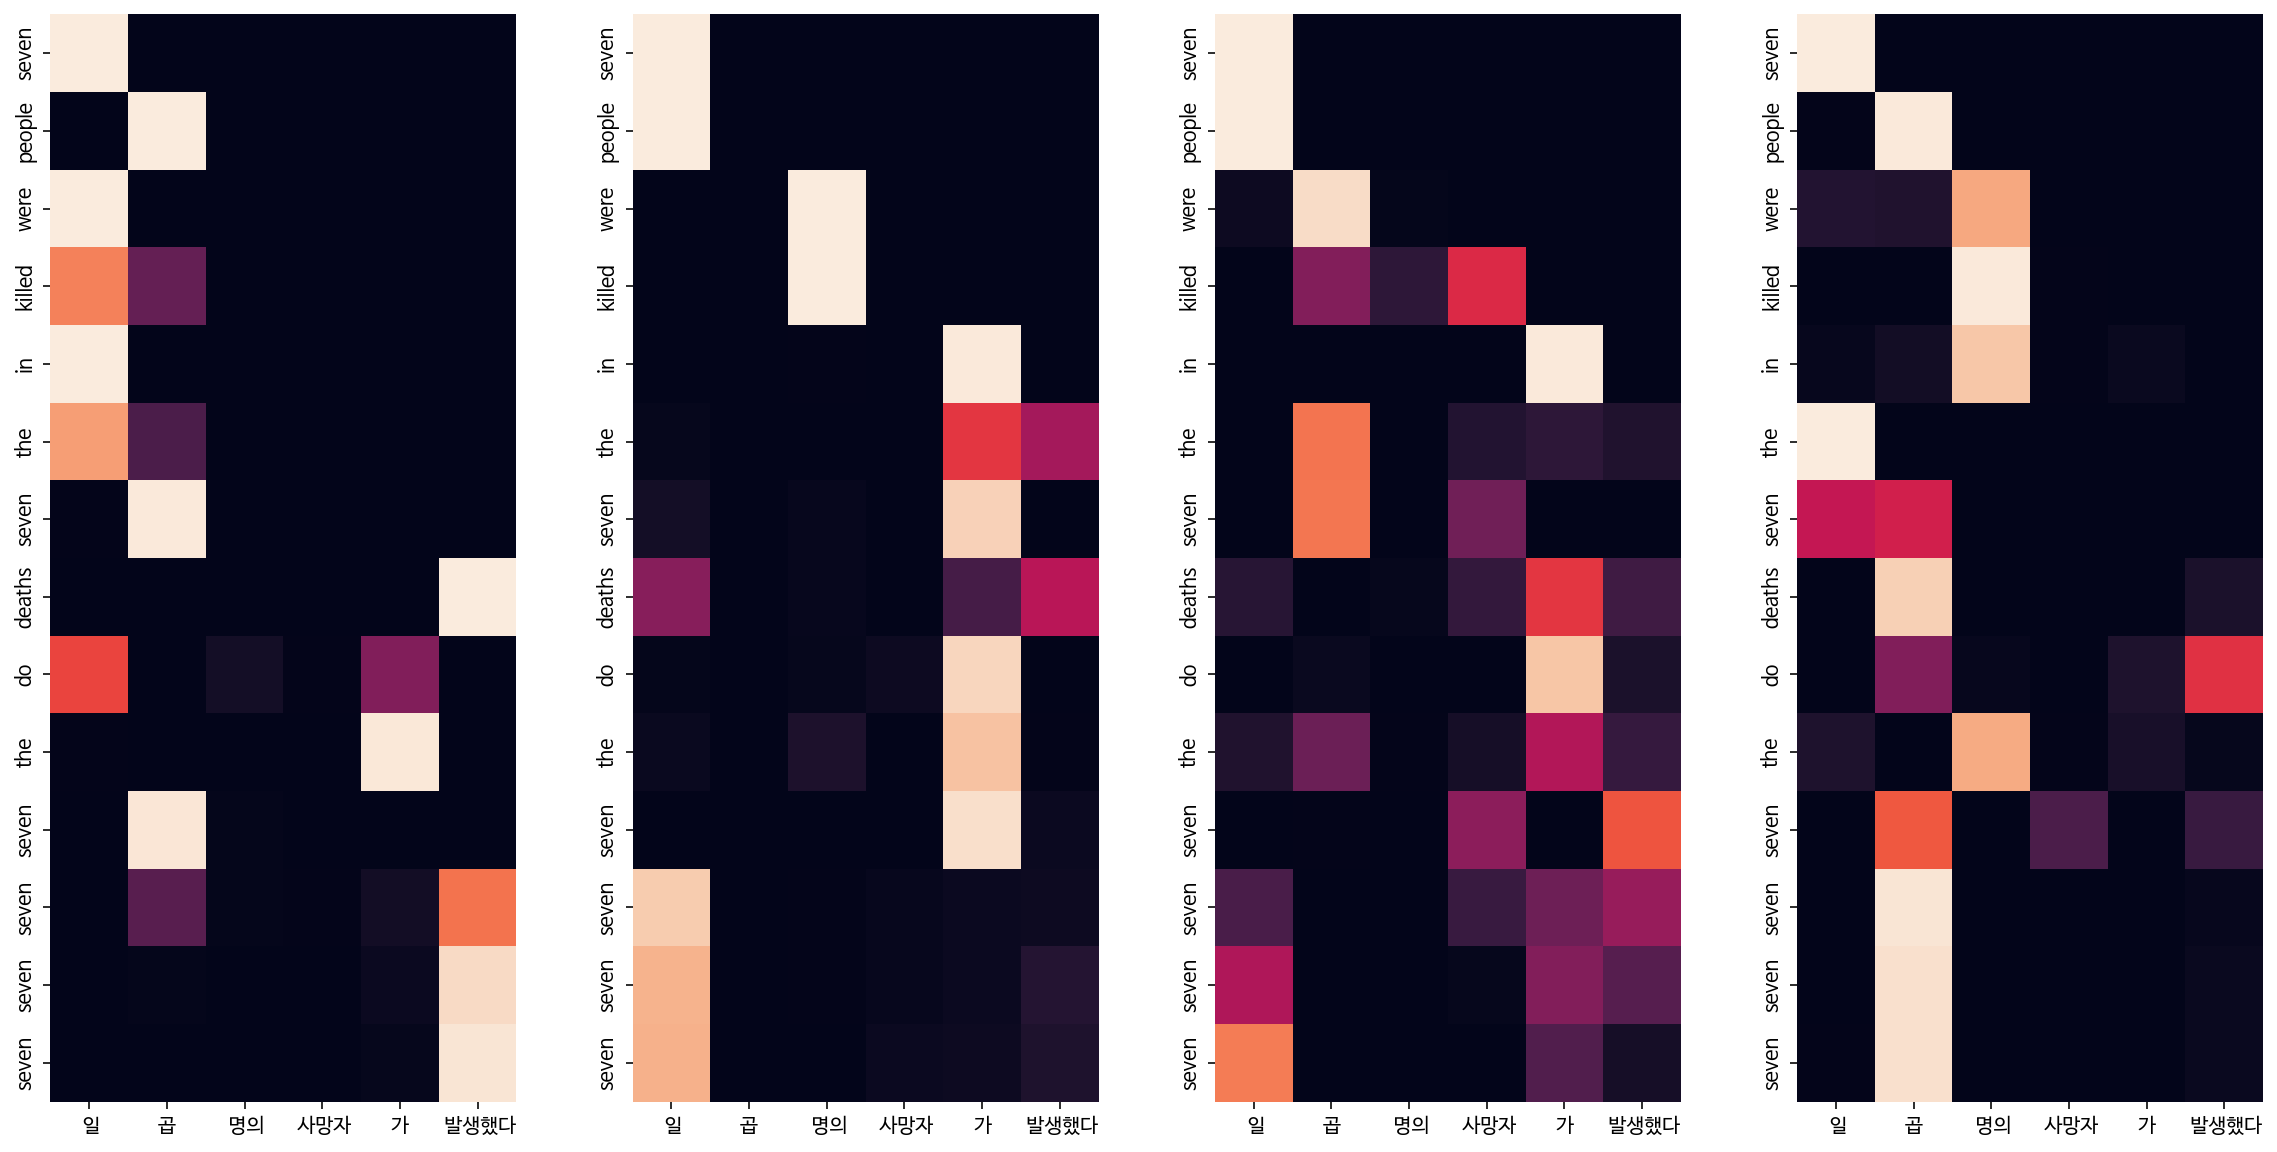

In [ ]:
for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

하지만 이 역시 어텐션 히트맵을 시각화해보면 프로젝트04와 마찬가지로

그냥 우연히 키워드가 등장한 것 같습니다.

- - -
## 마무리하며

프로젝트04에서 느낀 점으로 쓸만한 번역기를 만든다는 것은 쉽지 않은 일이란 것을 깨달았기에

이번 프로젝트의 목표는 `그래도 프로젝트04보단 성공적인 번역기를 만들자` 였습니다.

일단 목표는 성공했다고 볼 수 있지만 여전히 아쉬운 부분이 남습니다.

SentencePiece와 Mecab에서 형태소 분리 성능 차이가 좀 생기는 것도 느껴졌구요.

제가 생각하는 옳은 형태소 분석은 SentencePiece보단 Mecab이 더 가까웠거든요.

특히 SentencePiece는 `일곱`이란 단어를 `일`와 `곱`으로 나눴다는 부분에서 Mecab보다 아쉬웠지만 그래도 번역이 잘 됐으니까 된거겠죠.

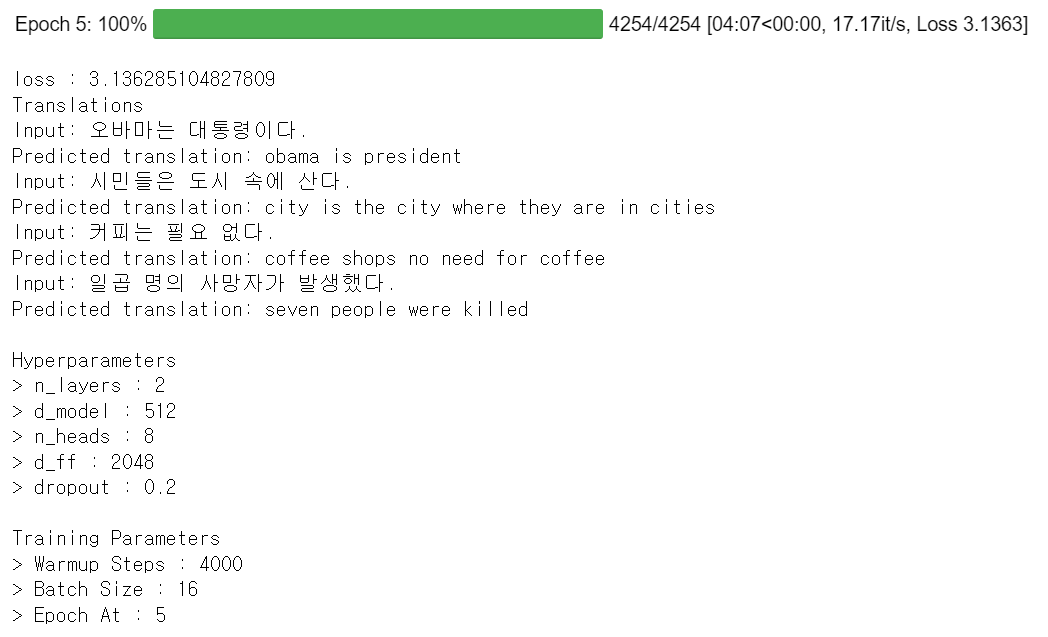

총 20Epochs를 진행하고 loss를 0.9까지 떨어뜨렸지만

아이러니하게도 가장 번역 품질이 좋았던 것은 loss 3.1362의 5 Epochs 결과였습니다.

두 번째와 세 번째 문장은 제대로 된 번역이 아니긴 하지만 이 정도만으로 만족해야겠습니다.

In [ ]:
# variables = model.encoder.trainable_variables + model.decoder.trainable_variables
# variables = model.trainable_variables

# 둘 중 뭐가 맞는 건지는 모르겠지만 후자가 번역 성능이 조금 더 좋았음.